## Drug Screening Panels Data Analysis

Import required packages and classes

In [1]:
import pharmacoset
import importlib
import utils
import calculations
import myPlots



In [2]:
importlib.reload(pharmacoset) 
importlib.reload(utils)
importlib.reload(myPlots)
importlib.reload(calculations)

from pharmacoset import PharmacoSet
from utils import Tools, DrugAnalysis
from calculations import Correlation
from myPlots import Plotting

### Create PharmacoSets
PharmacoSet class is defined in pharmacoset.py file.

In [3]:
gdsc_path = "../../data/processed_data/gdsc2_normalized_mapped.tsv"
ccle_path = "../../data/processed_data/ccle_normalized_mapped.tsv"

gdsc = PharmacoSet(filepath= gdsc_path, name= "gdsc2")
ccle = PharmacoSet(filepath= ccle_path, name= "ccle")
gdsc.data.head()


,cell_line,drug,dose,response,dataset
0,CVCL_1045,123138,0.000000,1.0,gdsc2
1,CVCL_1045,123138,0.001001,1.0,gdsc2
2,CVCL_1045,123138,0.003164,1.0,gdsc2
3,CVCL_1045,123138,0.010004,1.0,gdsc2
4,CVCL_1045,123138,0.031631,1.0,gdsc2


In [8]:
print(len(gdsc.data['cell_line'].unique()))
print(len(ccle.data['cell_line'].unique()))
print(len(gdsc.data['drug'].unique()))
print(len(ccle.data['drug'].unique()))

964
501
287
24


Find and filter overlapping cell line - drug pairs.
After using filter_common_pairs method, filtered data can be accessed from PharmacoSet object by '.overlapping_data' accessor. 

In [4]:
common_pairs = Tools.find_common_pairs(gdsc, ccle)


In [9]:
import pandas as pd
n_cell = len(pd.DataFrame(list(common_pairs))['cell_line'].unique())
n_drug = len(pd.DataFrame(list(common_pairs))['drug'].unique())
print(f"Number of overlapping cells: {n_cell}")
print(f"Number of overlapping drugs: {n_drug}")

Number of overlapping cells: 370
Number of overlapping drugs: 13


Filter overlapping cell-line drug pairs for each dataset.

In [10]:
gdsc.filter_common_pairs(common_pairs)
ccle.filter_common_pairs(common_pairs)

Find common concetration range of the overlapping data.

In [11]:
common_conc = Tools.common_concentration_ranges(gdsc.overlapping_data, ccle.overlapping_data)
common_conc.head()


,cell_line_,drug_,common_min_dose,common_max_dose
0,cvcl_0012,crizotinib,0.002500,8.0
1,cvcl_0012,erlotinib,0.010005,8.0
2,cvcl_0012,irinotecan,0.005003,5.0
3,cvcl_0012,lapatinib,0.010005,8.0
4,cvcl_0012,nilotinib,0.010005,8.0


Compute AUC between shared concentration range for all drugs across all cell lines for both CCLE and GDSC2.  
- I used the output curve parameters from CurveCurator to compute AUC values.  
- AUC value for a given cell - drug pairs are computed in shared concentration range.
- I used p_value and log_fc as QC metric to throw out the curves that does not satisfy the basic assumptions.

In [12]:

all_drug_ccle = ccle.get_recomp_auc_values(common_conc, p_filter= 0.05, log_fc= -0.5)
all_drug_gdsc = gdsc.get_recomp_auc_values(common_conc, p_filter= 0.05, log_fc= -0.5)

ccle.recomp_Aucs.head()


Recomputing AUCs for selumetinib across all cell lines, ccle
Recomputing AUCs for erlotinib across all cell lines, ccle
Recomputing AUCs for irinotecan across all cell lines, ccle
Recomputing AUCs for lapatinib across all cell lines, ccle
Recomputing AUCs for nilotinib across all cell lines, ccle
Recomputing AUCs for nutlin3 across all cell lines, ccle
Recomputing AUCs for palbociclib across all cell lines, ccle
Recomputing AUCs for crizotinib across all cell lines, ccle
Recomputing AUCs for plx4720 across all cell lines, ccle
Recomputing AUCs for paclitaxel across all cell lines, ccle
Recomputing AUCs for sorafenib across all cell lines, ccle
Recomputing AUCs for topotecan across all cell lines, ccle
Recomputing AUCs for pd0325901 across all cell lines, ccle
Recomputing AUCs for crizotinib across all cell lines, gdsc2
Recomputing AUCs for erlotinib across all cell lines, gdsc2
Recomputing AUCs for irinotecan across all cell lines, gdsc2
Recomputing AUCs for lapatinib across all cell l

,drug,cvcl_0023,cvcl_0026,cvcl_0039,cvcl_0040,cvcl_0060,cvcl_0069,cvcl_0077,cvcl_0099,cvcl_0126,...,cvcl_1702,cvcl_1714,cvcl_1764,cvcl_2060,cvcl_2092,cvcl_2613,cvcl_2961,cvcl_3007,cvcl_3881,cvcl_4647
0,selumetinib,0.307547,0.283935,0.554974,0.220516,0.412833,0.191545,0.186653,0.352129,0.062361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,erlotinib,0.030545,NaN,NaN,0.002785,0.056021,NaN,NaN,NaN,0.116942,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,irinotecan,0.407873,0.256881,0.271545,NaN,NaN,0.285969,NaN,NaN,0.604759,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,lapatinib,0.145298,NaN,NaN,NaN,NaN,NaN,NaN,0.061880,0.201149,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,nilotinib,0.004687,0.000057,0.068683,NaN,NaN,NaN,NaN,0.012600,0.000060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Plot the distribution of AUC values of Published and Recomputed for a given dataset. 
CCLE below

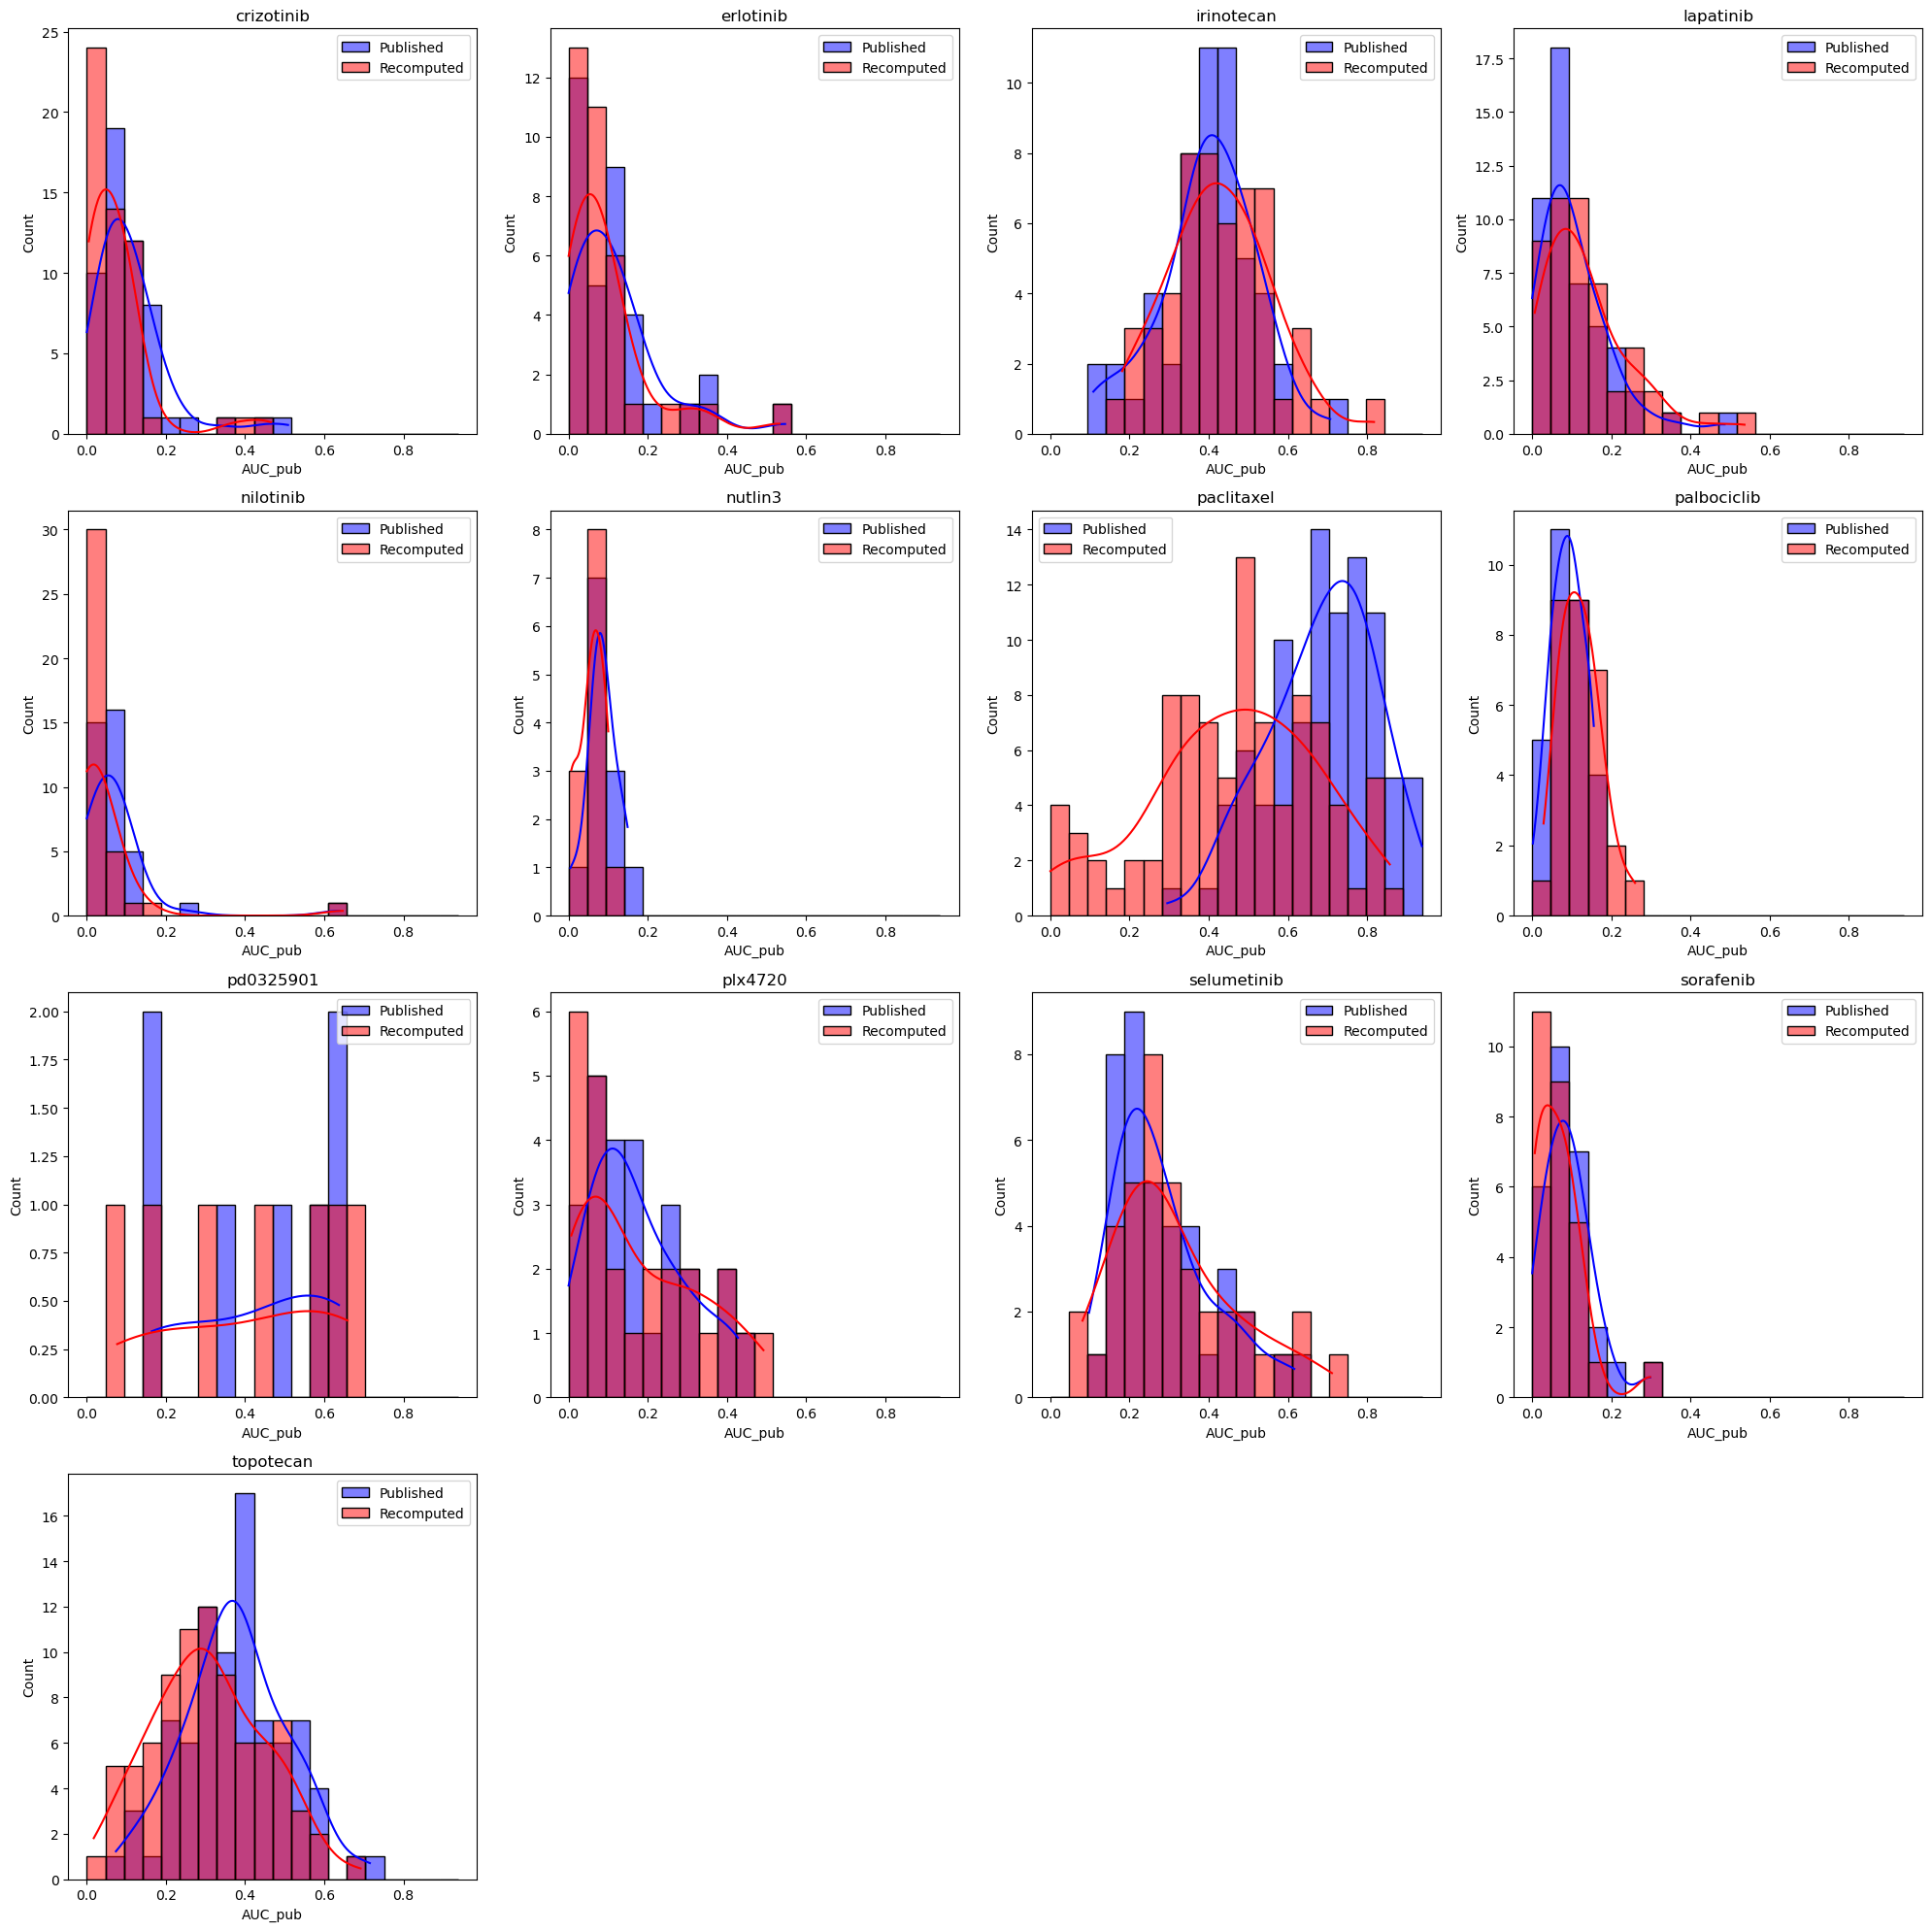

In [14]:
Plotting.plot_AUC_dist_pub_vs_recomp(ccle)

Plot the distribution of AUC values of Published and Recomputed for a given dataset. GDSC below.

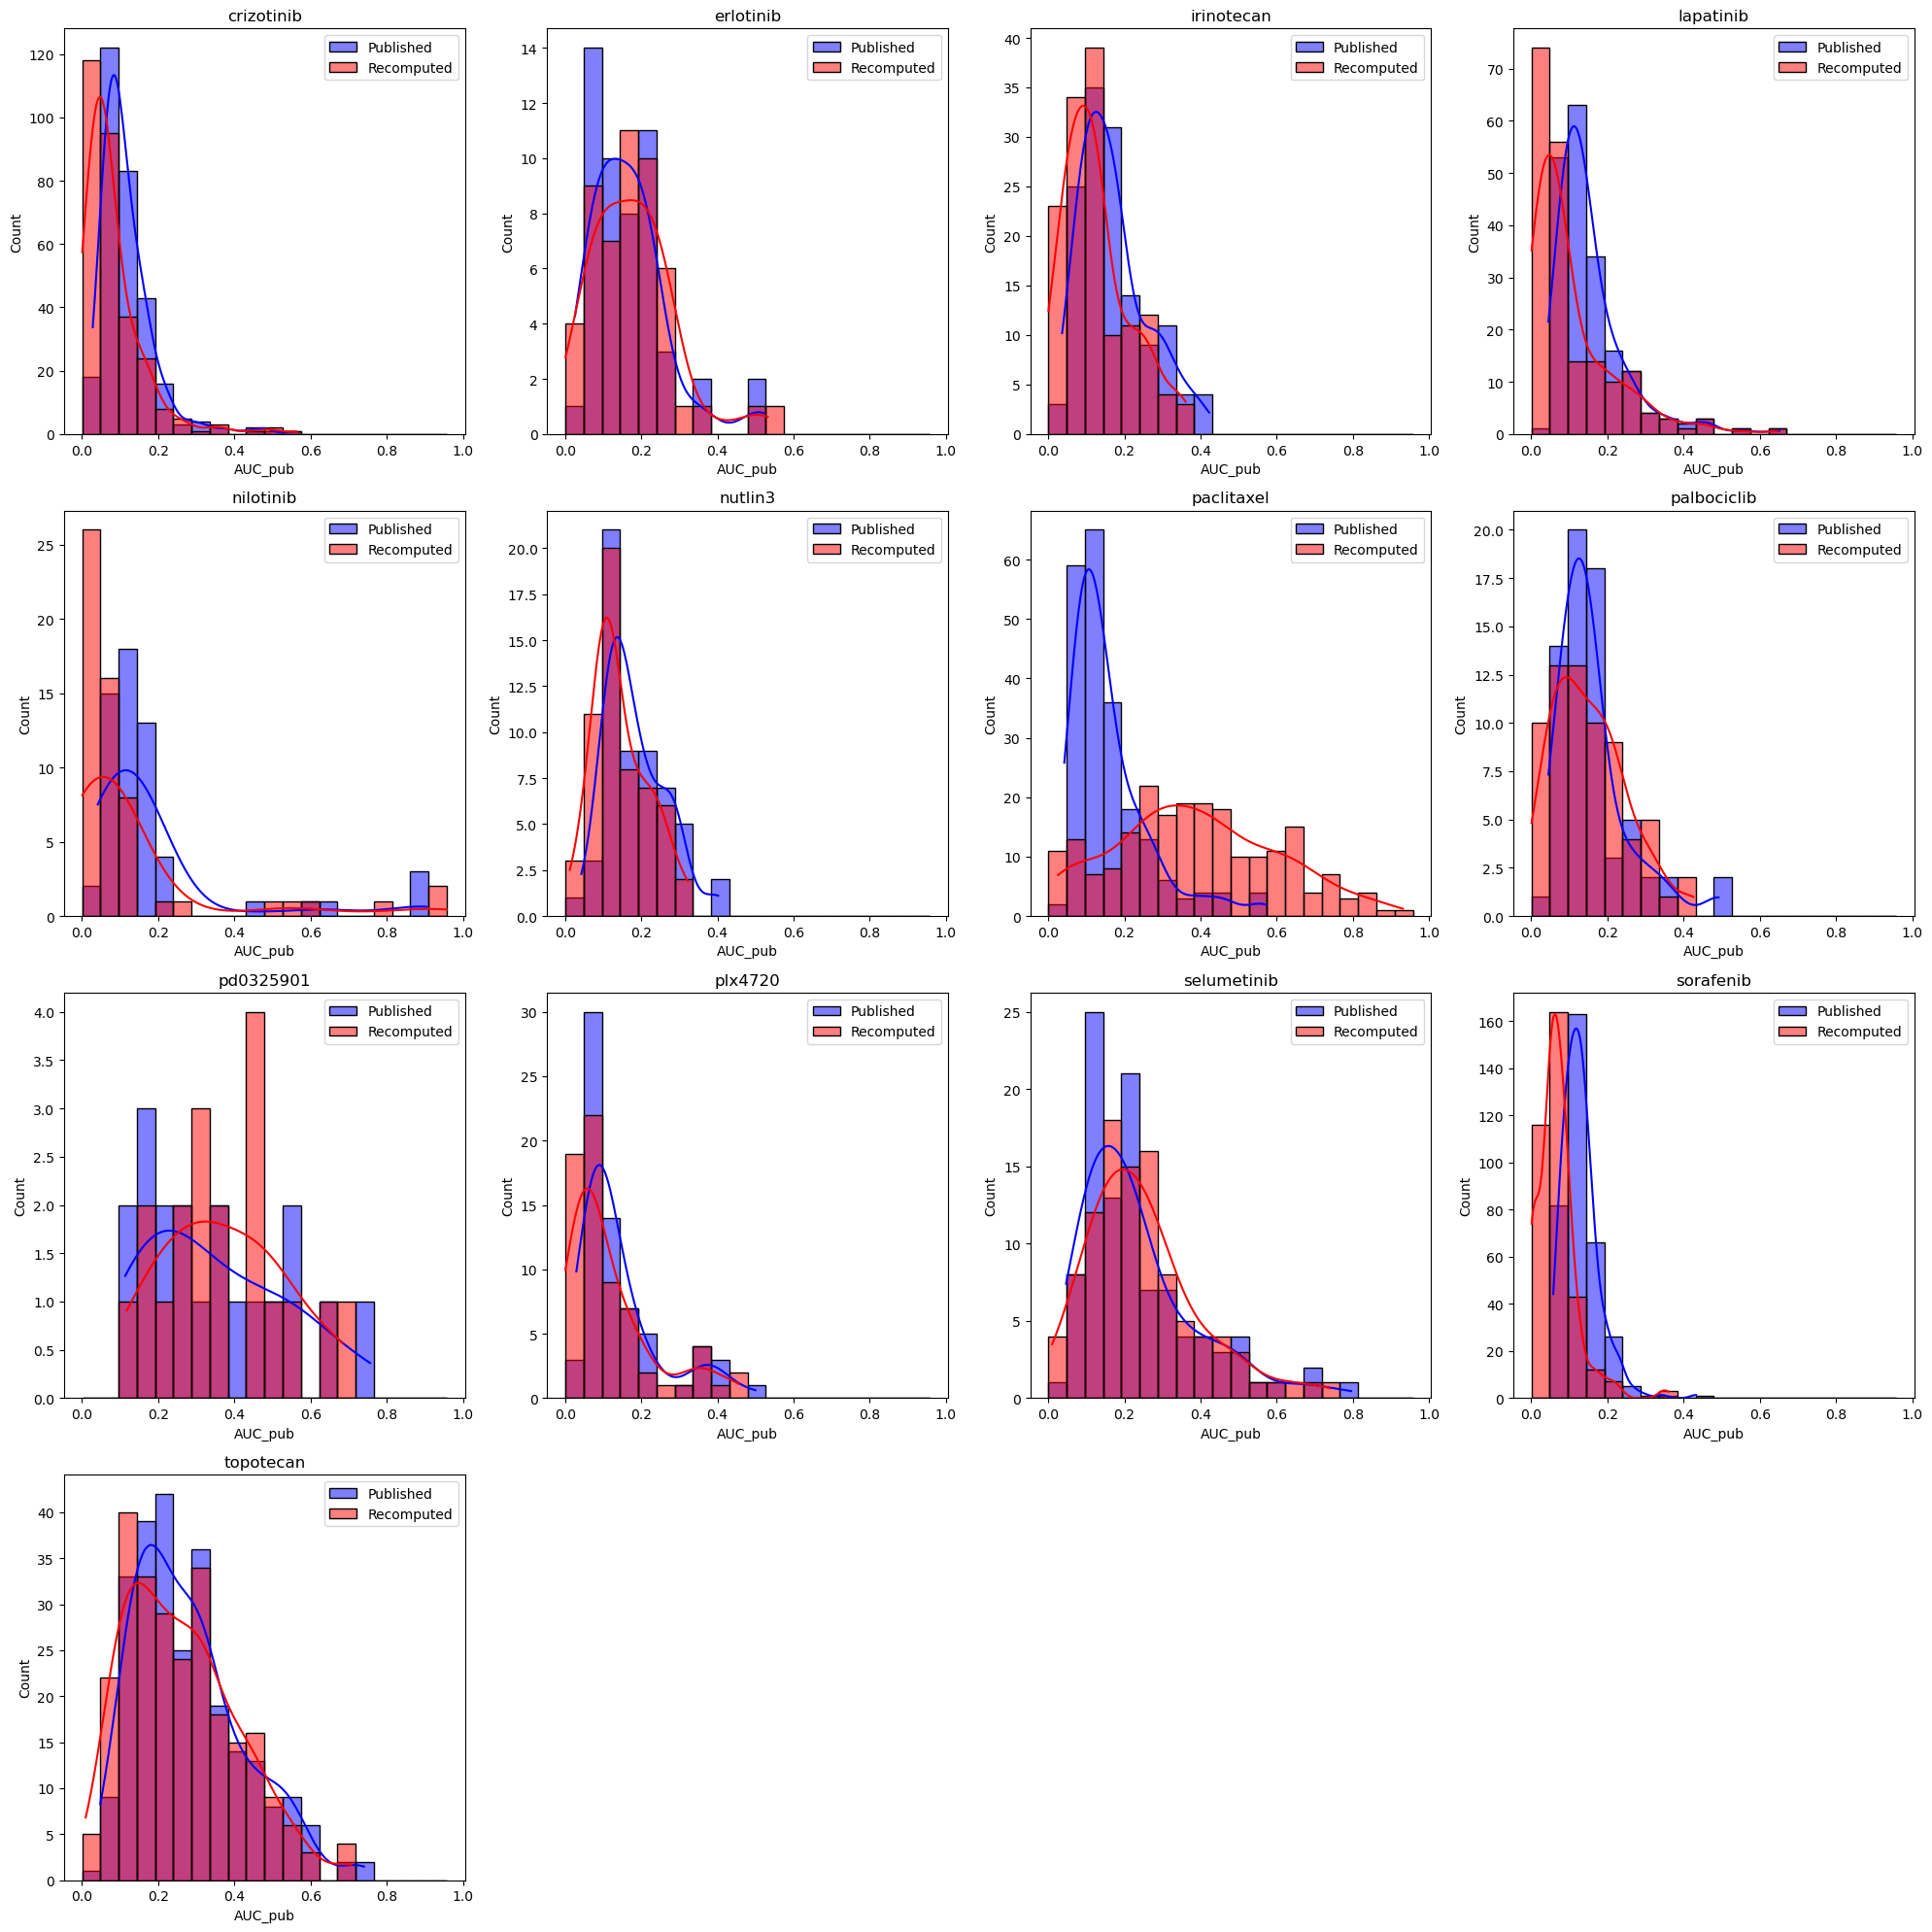

In [12]:
Plotting.plot_AUC_dist_pub_vs_recomp(gdsc)

Check the overall correlation between CCLE and GDSC published AUC values

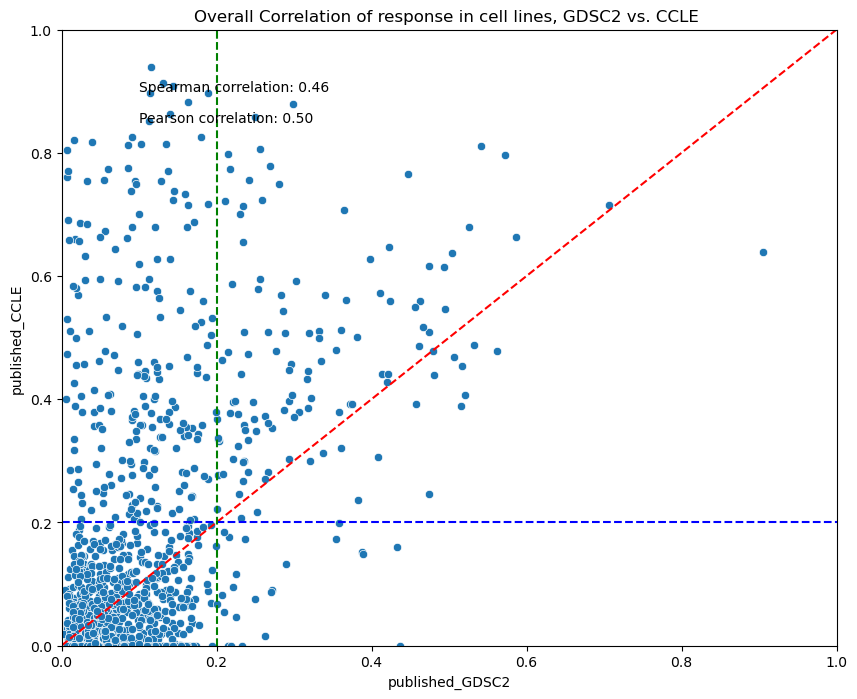

In [15]:
Plotting.correlation_plot_whole_pSet(gdsc, ccle, "published")

Check overall correlation between Recomputed AUC values.  
As it can be seen, only using CurveCurator resulted in better consistency.

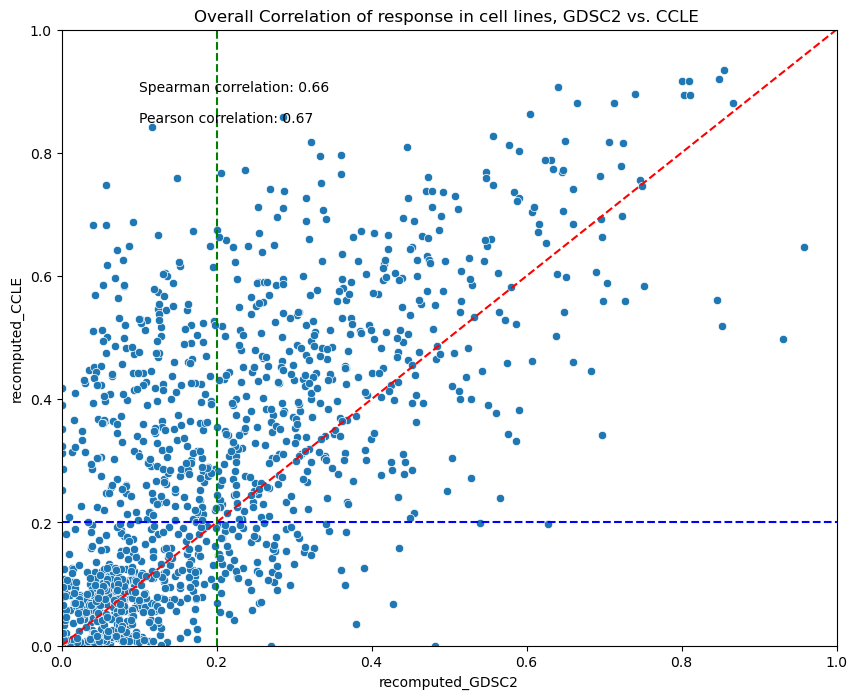

In [16]:
Plotting.correlation_plot_whole_pSet(gdsc, ccle, "recomputed")

I'll compute the correlation for each drug seperately, and create a table.

In [17]:
res_pearson = Correlation.recomp_vs_pub_corr_table(ccle, gdsc, "pearson")
res_pearson

,drug,pub_corr,recomp_corr,pub_size,recomp_size,p-value
0,crizotinib,0.670302,0.719290,98,174,0.458400
1,erlotinib,0.777750,0.732895,97,43,0.579172
2,irinotecan,0.684417,0.703954,54,136,0.818858
3,lapatinib,0.686769,0.782365,98,122,0.127607
4,nilotinib,0.733883,0.898026,78,35,0.012932
5,nutlin3,0.331435,0.566913,98,18,0.282619
6,plx4720,0.770511,0.682253,97,38,0.341717
7,paclitaxel,0.400062,0.505913,98,204,0.283614
8,palbociclib,0.275737,0.628824,85,40,0.021192
9,selumetinib,0.713667,0.744251,98,82,0.667906


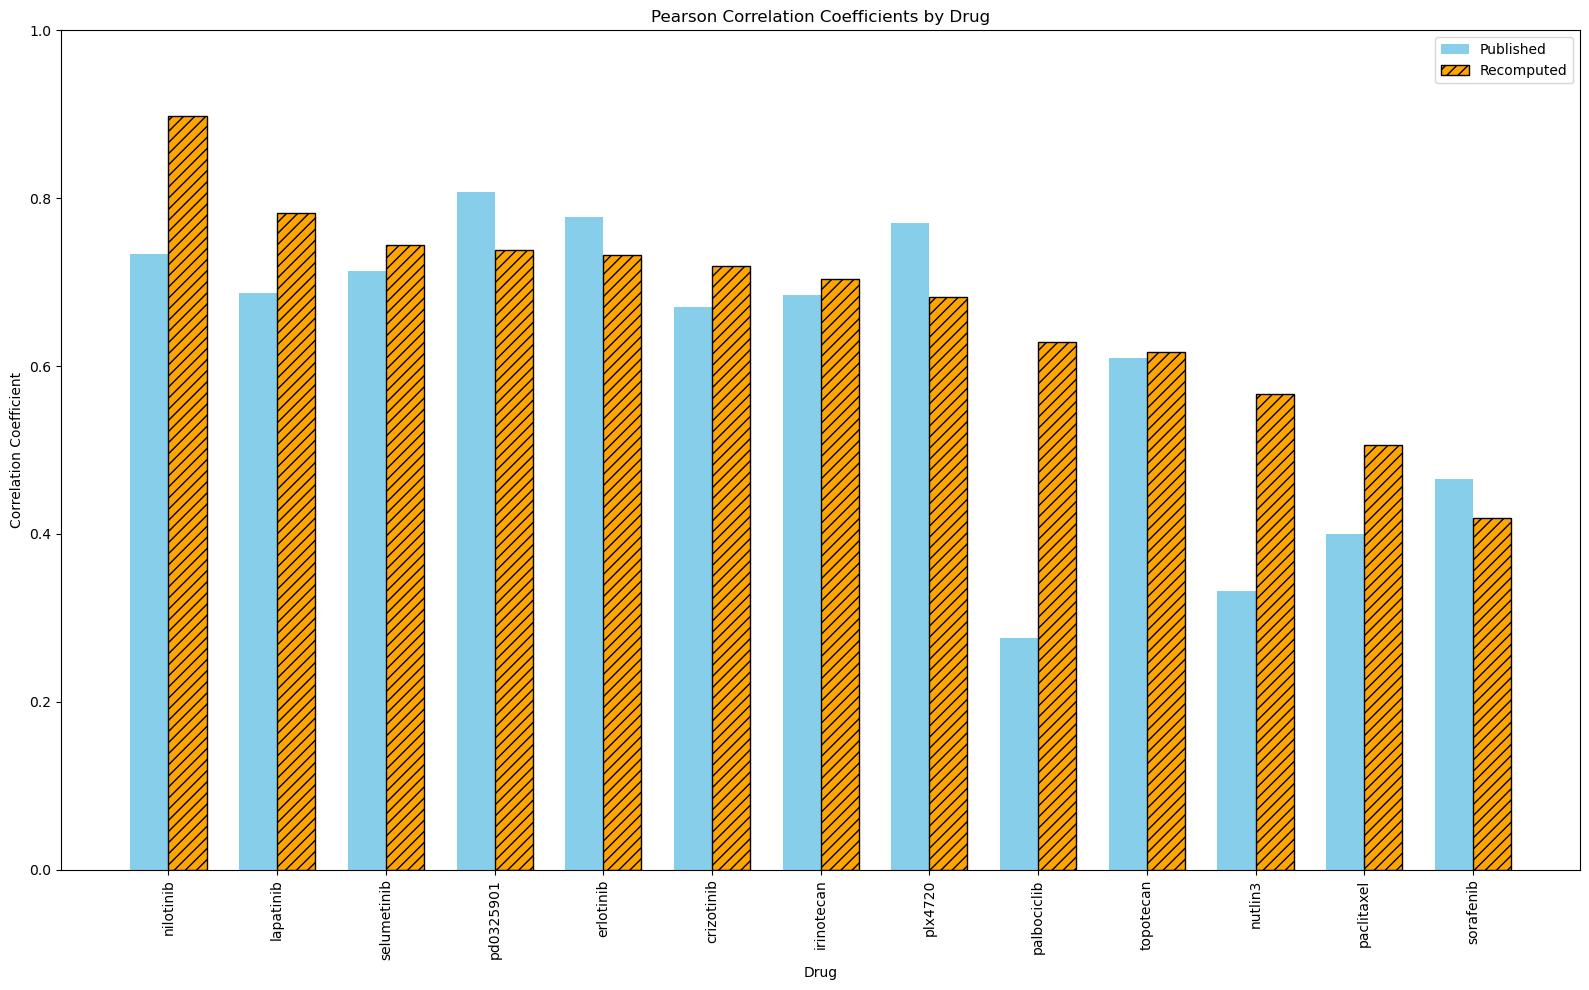

In [18]:
Plotting.barplot_corr_table(res_pearson, "Pearson")

The most significant difference between published and recomputed is observed in palbociclib.  
To see how it looks like in scatter plot, I will plot only palbociclib.  

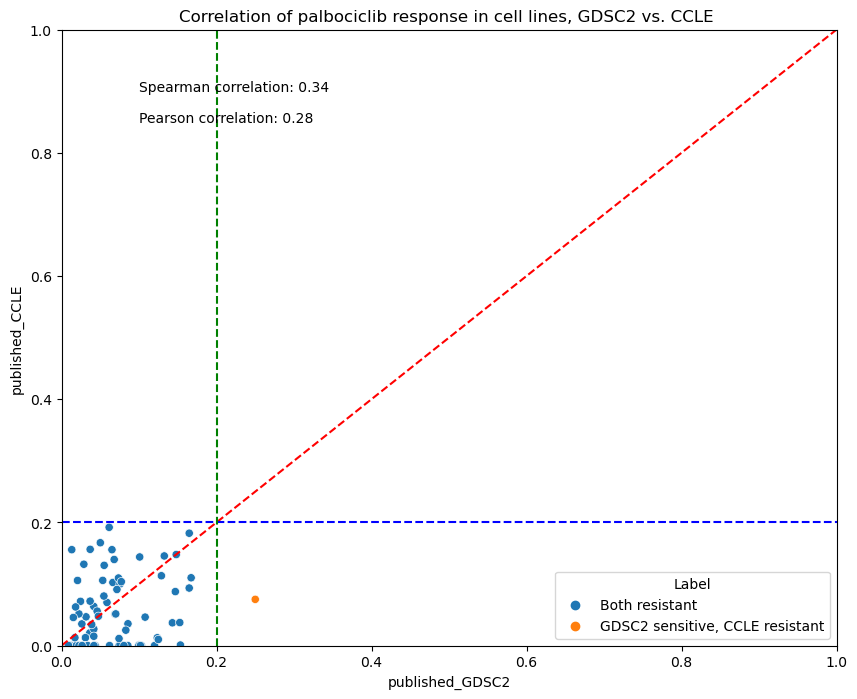

In [19]:
Plotting.correlation_plot(gdsc, ccle, "palbociclib", method= 'published')

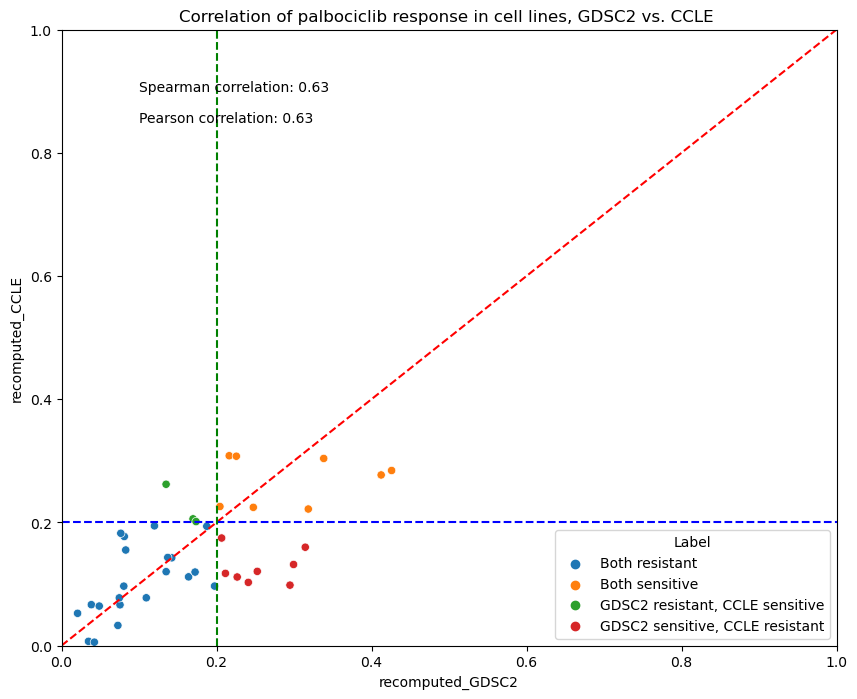

In [20]:
Plotting.correlation_plot(gdsc, ccle, "palbociclib", method= 'recomputed')

## In-depth look at variance across AUC values 

In [36]:
importlib.reload(pharmacoset) 
importlib.reload(utils)
importlib.reload(myPlots)

from pharmacoset import PharmacoSet
from utils import Tools, DrugAnalysis
from calculations import Correlation
from myPlots import Plotting

In [24]:
#Plotting.plot_waterfall(gdsc.recomp_Aucs, 'irinotecan')

In [23]:
#Plotting.plot_waterfall(ccle.recomp_Aucs, 'irinotecan')

Filter the overlapping drug-cell line pairs across published and recomputed datasets so that we can better compare published vs recomputed AUCs.

In [25]:

pub_gdsc, recomp_gdsc = calculations.fetch_data(gdsc)
pub_ccle, recomp_ccle = calculations.fetch_data(ccle)

pub_ccle.columns= pub_ccle.columns.str.lower()
pub_gdsc.columns= pub_gdsc.columns.str.lower()


In [26]:

pub_ccle_melt = pub_ccle.melt(id_vars=['drug'], var_name='cell_line', value_name='auc')
pub_gdsc_melt = pub_gdsc.melt(id_vars=['drug'], var_name='cell_line', value_name='auc')
recomp_gdsc_melt = recomp_gdsc.melt(id_vars=['drug'], var_name='cell_line', value_name='auc')
recomp_ccle_melt = recomp_ccle.melt(id_vars=['drug'], var_name='cell_line', value_name='auc')

In [27]:
pub_merged = pd.merge(pub_ccle_melt, pub_gdsc_melt, how = 'inner' , on = ['drug', 'cell_line'], suffixes= ['_ccle_pub', '_gdsc_pub']).dropna(subset= ['auc_ccle_pub', 'auc_gdsc_pub'])
pub_merged.head()

,drug,cell_line,auc_ccle_pub,auc_gdsc_pub
0,selumetinib,cvcl_1547,0.129375,0.039518
1,erlotinib,cvcl_1547,0.000000,0.013616
3,lapatinib,cvcl_1547,0.000000,0.020619
4,nilotinib,cvcl_1547,0.010525,0.008956
5,nutlin3,cvcl_1547,0.066550,0.017830


In [28]:
recomp_merged = pd.merge(recomp_ccle_melt, recomp_gdsc_melt, how = 'inner' , on = ['drug', 'cell_line'], suffixes= ['_ccle', '_gdsc']).dropna(subset= ['auc_ccle', 'auc_gdsc'])
len(recomp_merged['cell_line'].unique())

353

In [29]:
all_merged = pd.merge(pub_merged, recomp_merged, how= 'inner', on= ['drug', 'cell_line'])
all_merged

,drug,cell_line,auc_ccle_pub,auc_gdsc_pub,auc_ccle,auc_gdsc
0,topotecan,cvcl_1547,0.317525,0.118872,0.157705,0.134484
1,topotecan,cvcl_1544,0.288750,0.105442,0.114627,0.049245
2,irinotecan,cvcl_0153,0.459875,0.119690,0.483066,0.082790
3,paclitaxel,cvcl_0153,0.815000,0.102248,0.670211,0.403273
4,crizotinib,cvcl_0153,0.059187,0.123479,0.024310,0.076029
...,...,...,...,...,...,...
357,plx4720,cvcl_1780,0.427912,0.419625,0.492347,0.440406
358,topotecan,cvcl_1780,0.461213,0.335033,0.418227,0.329841
359,irinotecan,cvcl_0465,0.386450,0.049541,0.410330,0.016805
360,paclitaxel,cvcl_0465,0.655000,0.234778,0.629672,0.526060


I will calculate absolute difference between published AUC values and create a heatmap. So that I can see which drug-cell line pairs are differing (inconsistent) most for their AUC values.  
Note: This is not the best way to quantify the difference, since the curves could be quite different but have the same AUC values.  
But since we don't have the curve parameters for published AUCs, it is the only way to compare the published ones.

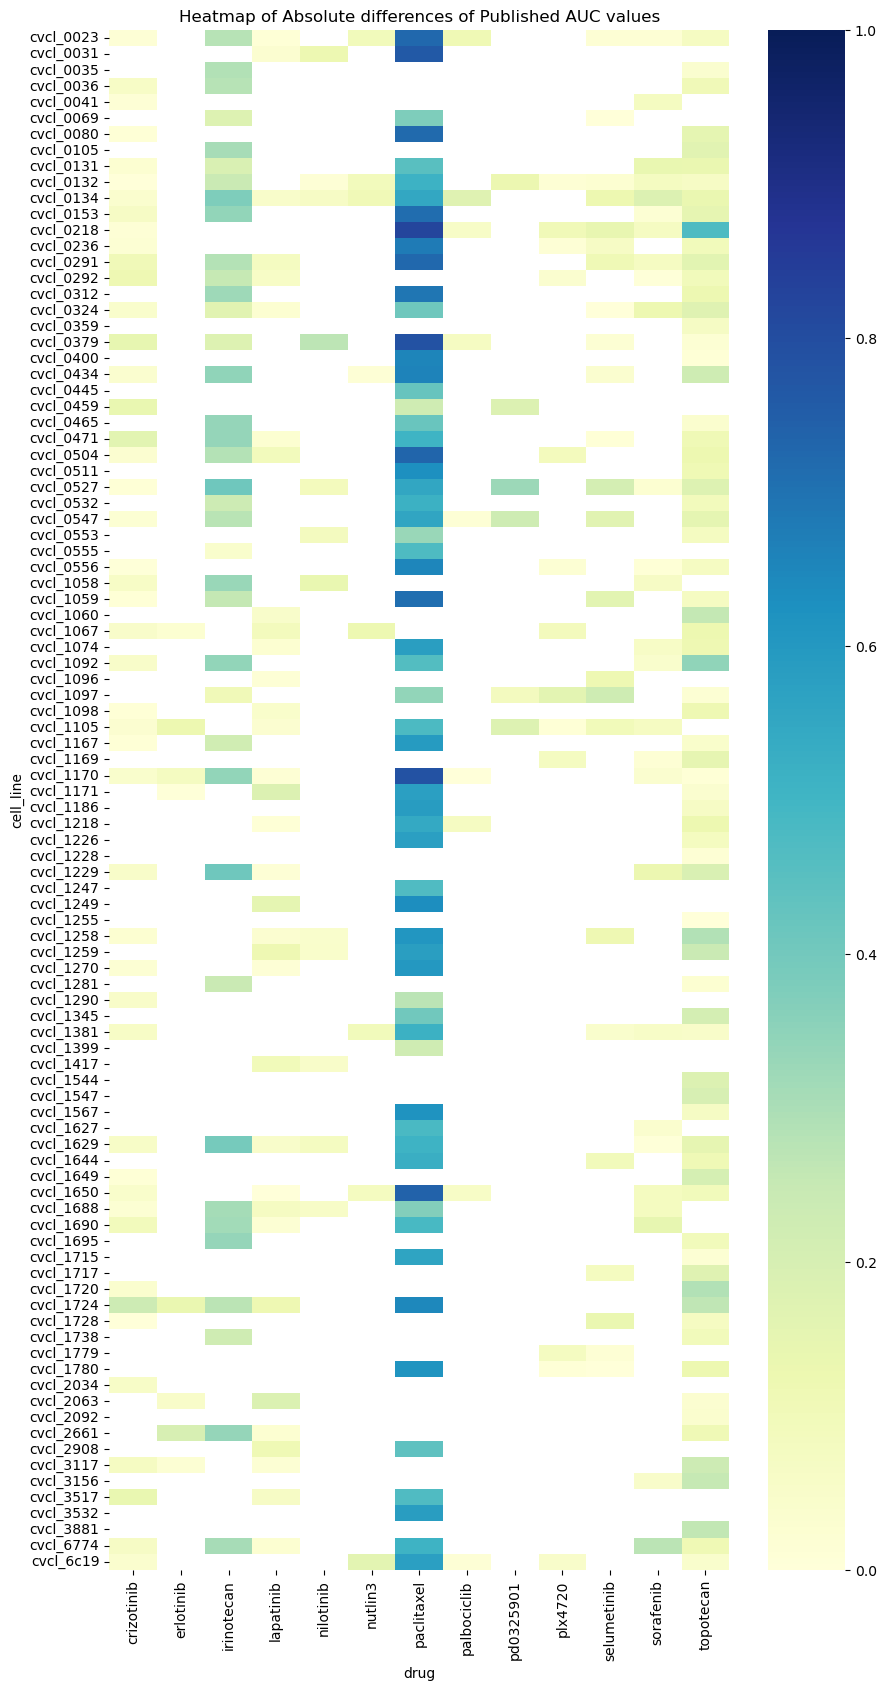

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

df = all_merged.copy()


df['abs_diff_pub'] = abs(df['auc_ccle_pub'] - df['auc_gdsc_pub'])
df['abs_diff_recomp'] = abs(df['auc_ccle'] - df['auc_gdsc'])

# Pivot the DataFrame to prepare for the heatmap
df_pivot = df.pivot_table(values='abs_diff_pub', index='cell_line', columns='drug')



plt.figure(figsize=(10, 20))
sns.heatmap(df_pivot, annot=False, cmap="YlGnBu", vmin=0, vmax=1)
plt.title('Heatmap of Absolute differences of Published AUC values')
plt.show()



I will do the same for the Recomputed values so that I can see which cell-drugs get better and which does not.

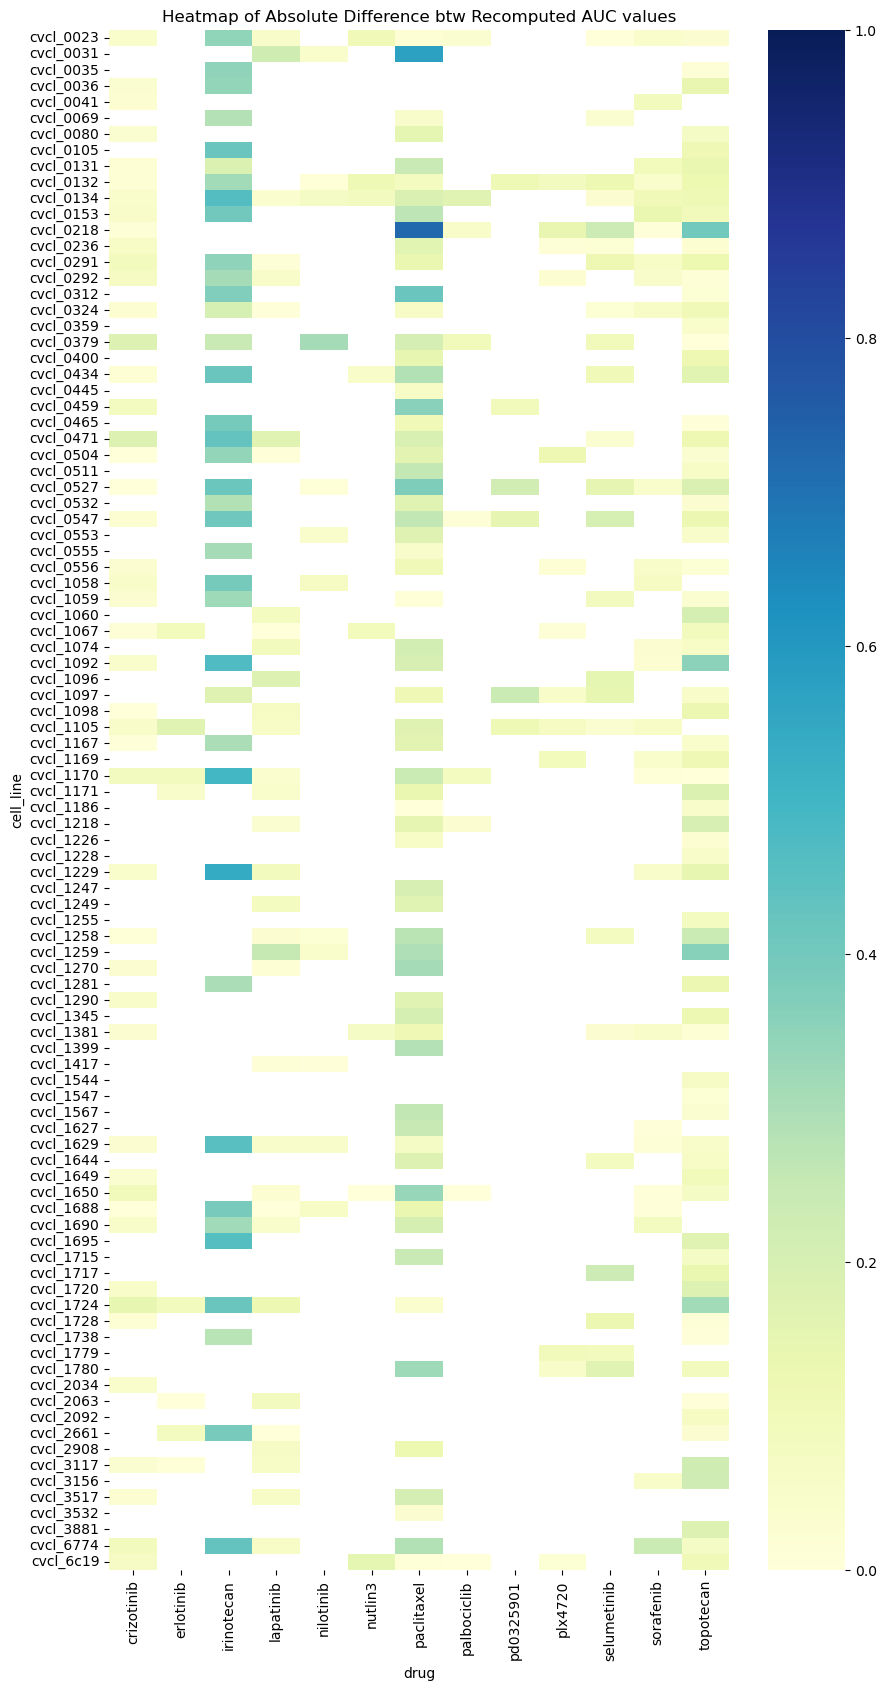

In [31]:
# Pivot the DataFrame to prepare for the heatmap
df_pivot = df.pivot_table(values='abs_diff_recomp', index='cell_line', columns='drug')



plt.figure(figsize=(10, 20))
sns.heatmap(df_pivot, annot=False, cmap="YlGnBu", vmin=0, vmax=1)
plt.title('Heatmap of Absolute Difference btw Recomputed AUC values')
plt.show()

Let's check which cell-drug pair got the best improvement from recomputation.

In [32]:
df['diff_of_diff'] = df['abs_diff_pub'] - df['abs_diff_recomp']
df.sort_values(by=['diff_of_diff'], ascending=False)

,drug,cell_line,auc_ccle_pub,auc_gdsc_pub,auc_ccle,auc_gdsc,abs_diff_pub,abs_diff_recomp,diff_of_diff
242,paclitaxel,cvcl_0023,0.863750,0.140015,0.464348,0.447608,0.723735,0.016740,0.706995
347,paclitaxel,cvcl_1059,0.897500,0.189418,0.755262,0.746901,0.708082,0.008361,0.699721
271,paclitaxel,cvcl_1724,0.825000,0.179860,0.602667,0.638880,0.645140,0.036213,0.608927
328,paclitaxel,cvcl_0291,0.812500,0.086216,0.506317,0.372725,0.726284,0.133592,0.592692
294,paclitaxel,cvcl_1186,0.678750,0.090359,0.349568,0.352978,0.588391,0.003410,0.584981
...,...,...,...,...,...,...,...,...,...
210,pd0325901,cvcl_1097,0.478250,0.561374,0.445122,0.683383,0.083124,0.238262,-0.155138
118,lapatinib,cvcl_1096,0.153388,0.138064,0.259647,0.083445,0.015324,0.176202,-0.160878
355,selumetinib,cvcl_1780,0.478300,0.479094,0.626621,0.458023,0.000794,0.168598,-0.167803
222,lapatinib,cvcl_0031,0.126862,0.156315,0.275277,0.050799,0.029453,0.224478,-0.195025


The best improvement is found to be in CVCL_0023 treated with paclitaxel.  
Apperently, the reason why published values are not consistent is resulted from the fact that they were measured in different dose range.  
As it can be seen below.

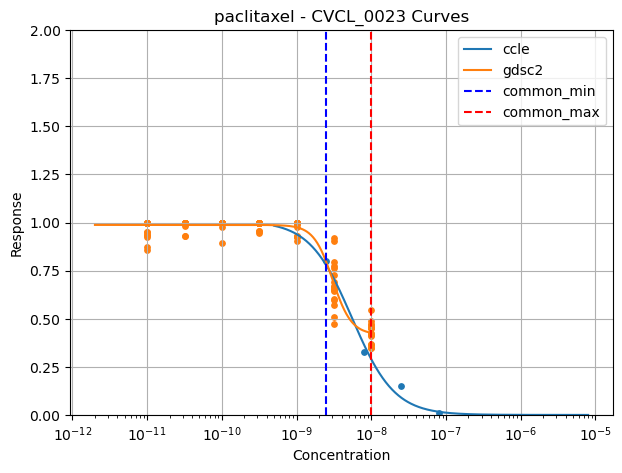

In [33]:
Plotting.plot_sigmoid_curves(ccle, gdsc, 'paclitaxel', 'CVCL_0023', common_conc= common_conc)

Irinotecan - CVCL_0555 got worse after recomputation.  
When you check why by plotting curves below based on refitted parameters, it is obvious that we need to define a new metric to quantify consistency between recomputed values. 

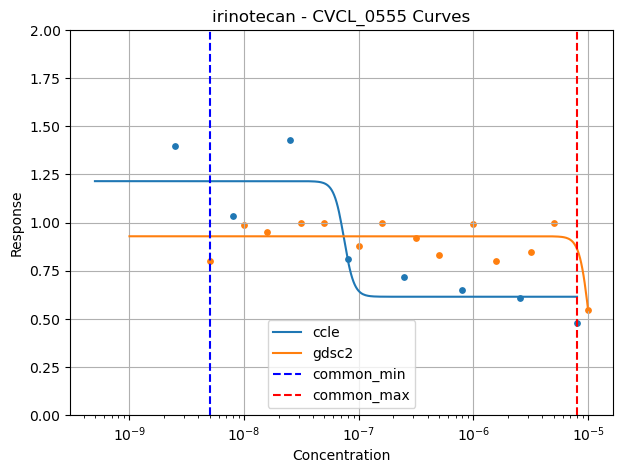

In [34]:
Plotting.plot_sigmoid_curves(ccle, gdsc, 'irinotecan', 'CVCL_0555', common_conc= common_conc)

Below, I'm going to calculate Area Between Curve (ABC) as a measure of consistency.  
It is basically, the integral of the differences of the two curves (abs_diff_func = lambda x: np.abs(f1(x) - f2(x)))    ->> Note that: absolute is optional with the last parameter of the function


normalized over shared concentration range, so it has unit 'length'.  

In other word, it shows average distance between the points of the two curves. 

If absolute is true: 
    It's between 0-1
    0 = perfect consistency, 1 = perfect inconsistency.

In [37]:
def apply_compute_ABC(row, pSet1, pSet2):
    return Tools.compute_ABC(pSet1, pSet2, row['drug'], row['cell_line'], common_conc, abs = True)

recomp_df = recomp_merged.copy() 

recomp_df['ABC'] = recomp_df.apply(apply_compute_ABC, args=(ccle, gdsc), axis=1)

sorted_ABC = recomp_df.sort_values(by = 'ABC', ascending= False)

sorted_ABC


,drug,cell_line,auc_ccle,auc_gdsc,ABC
191,paclitaxel,cvcl_0218,0.841452,0.116585,0.724886
3883,paclitaxel,cvcl_1818,0.747101,0.057016,0.690144
87,paclitaxel,cvcl_0077,0.683185,0.057522,0.625778
1790,paclitaxel,cvcl_1823,0.688115,0.092788,0.595331
1542,plx4720,cvcl_1694,0.759344,0.149304,0.584298
...,...,...,...,...,...
3344,lapatinib,cvcl_1087,0.055581,0.048472,0.018997
3543,crizotinib,cvcl_1361,0.043522,0.049817,0.017840
3271,plx4720,cvcl_0556,0.041511,0.024327,0.017106
1076,sorafenib,cvcl_1402,0.073195,0.078335,0.011869


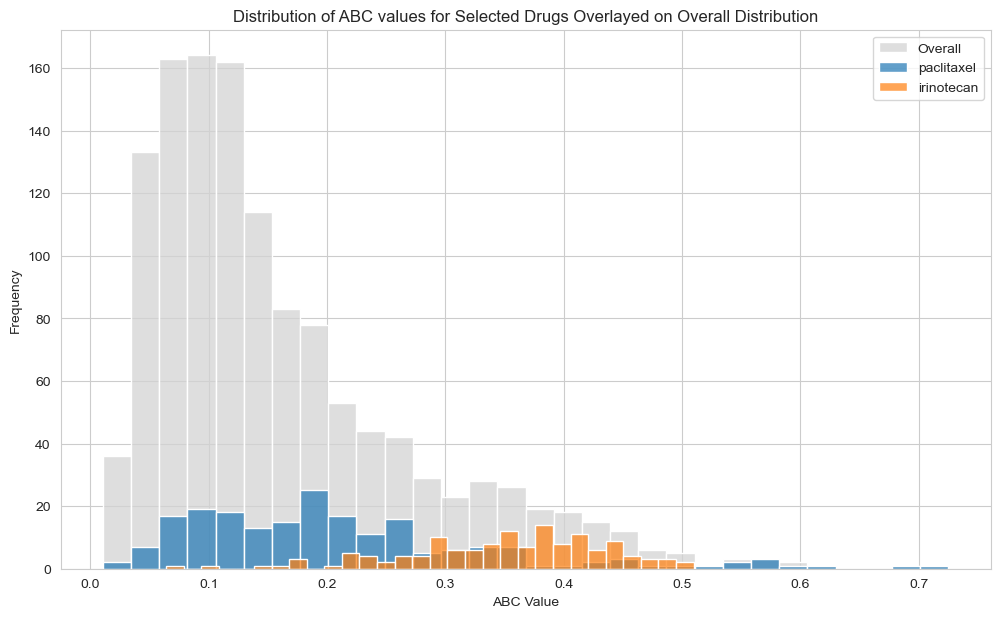

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Set the style for seaborn
sns.set_style("whitegrid")

# List of drugs you are interested in
selected_drugs = ['paclitaxel', 'irinotecan']

plt.figure(figsize=(12, 7))

# Plot overall ABC distribution first
sns.histplot(sorted_ABC['ABC'], kde=False, bins=30, label='Overall', color='lightgray')

# Loop through each drug and overlay its histogram
for drug in selected_drugs:
    subset = sorted_ABC[sorted_ABC['drug'] == drug]
    sns.histplot(subset['ABC'], kde=False, label=drug, bins=30, alpha=0.7)

# Title, labels, and legend
plt.title('Distribution of ABC values for Selected Drugs Overlayed on Overall Distribution')
plt.xlabel('ABC Value')
plt.ylabel('Frequency')
plt.legend()

plt.show()


Most inconsistent pair below

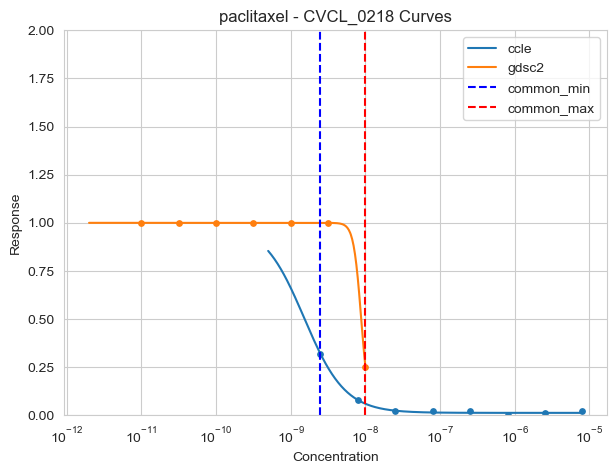

In [40]:
Plotting.plot_sigmoid_curves(ccle, gdsc, 'paclitaxel', 'CVCL_0218', common_conc= common_conc)

I want to see the distribution of ABC for each drug

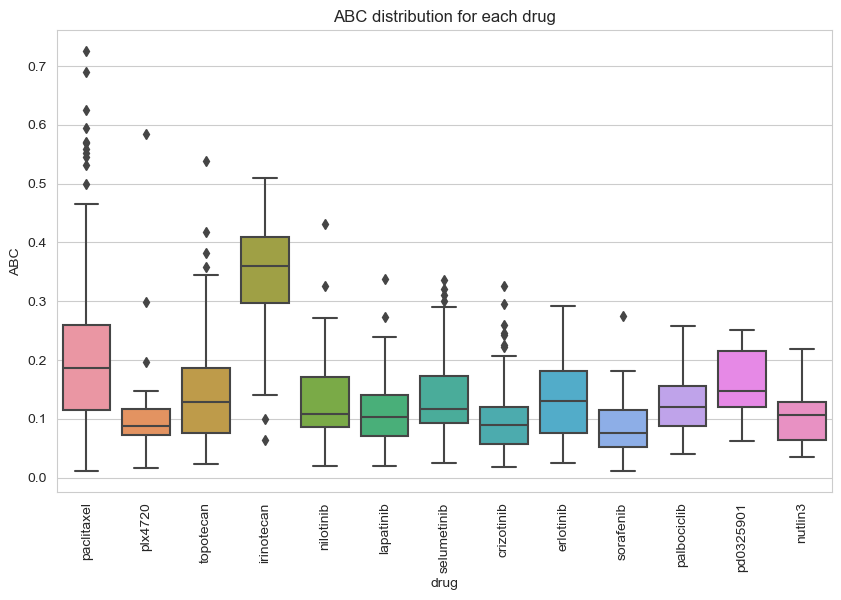

In [41]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='drug', y='ABC', data=sorted_ABC)
plt.xticks(rotation=90)
plt.title('ABC distribution for each drug')
plt.show()

As it can be seen above boxplot, the most inconsistent drug is found to be 'irinotecan'.  
Therefore, I want to plot the most inconsistent cell line - irinotecan pairs.

Irinotecan: Topoisomarase I (cytotoxic)

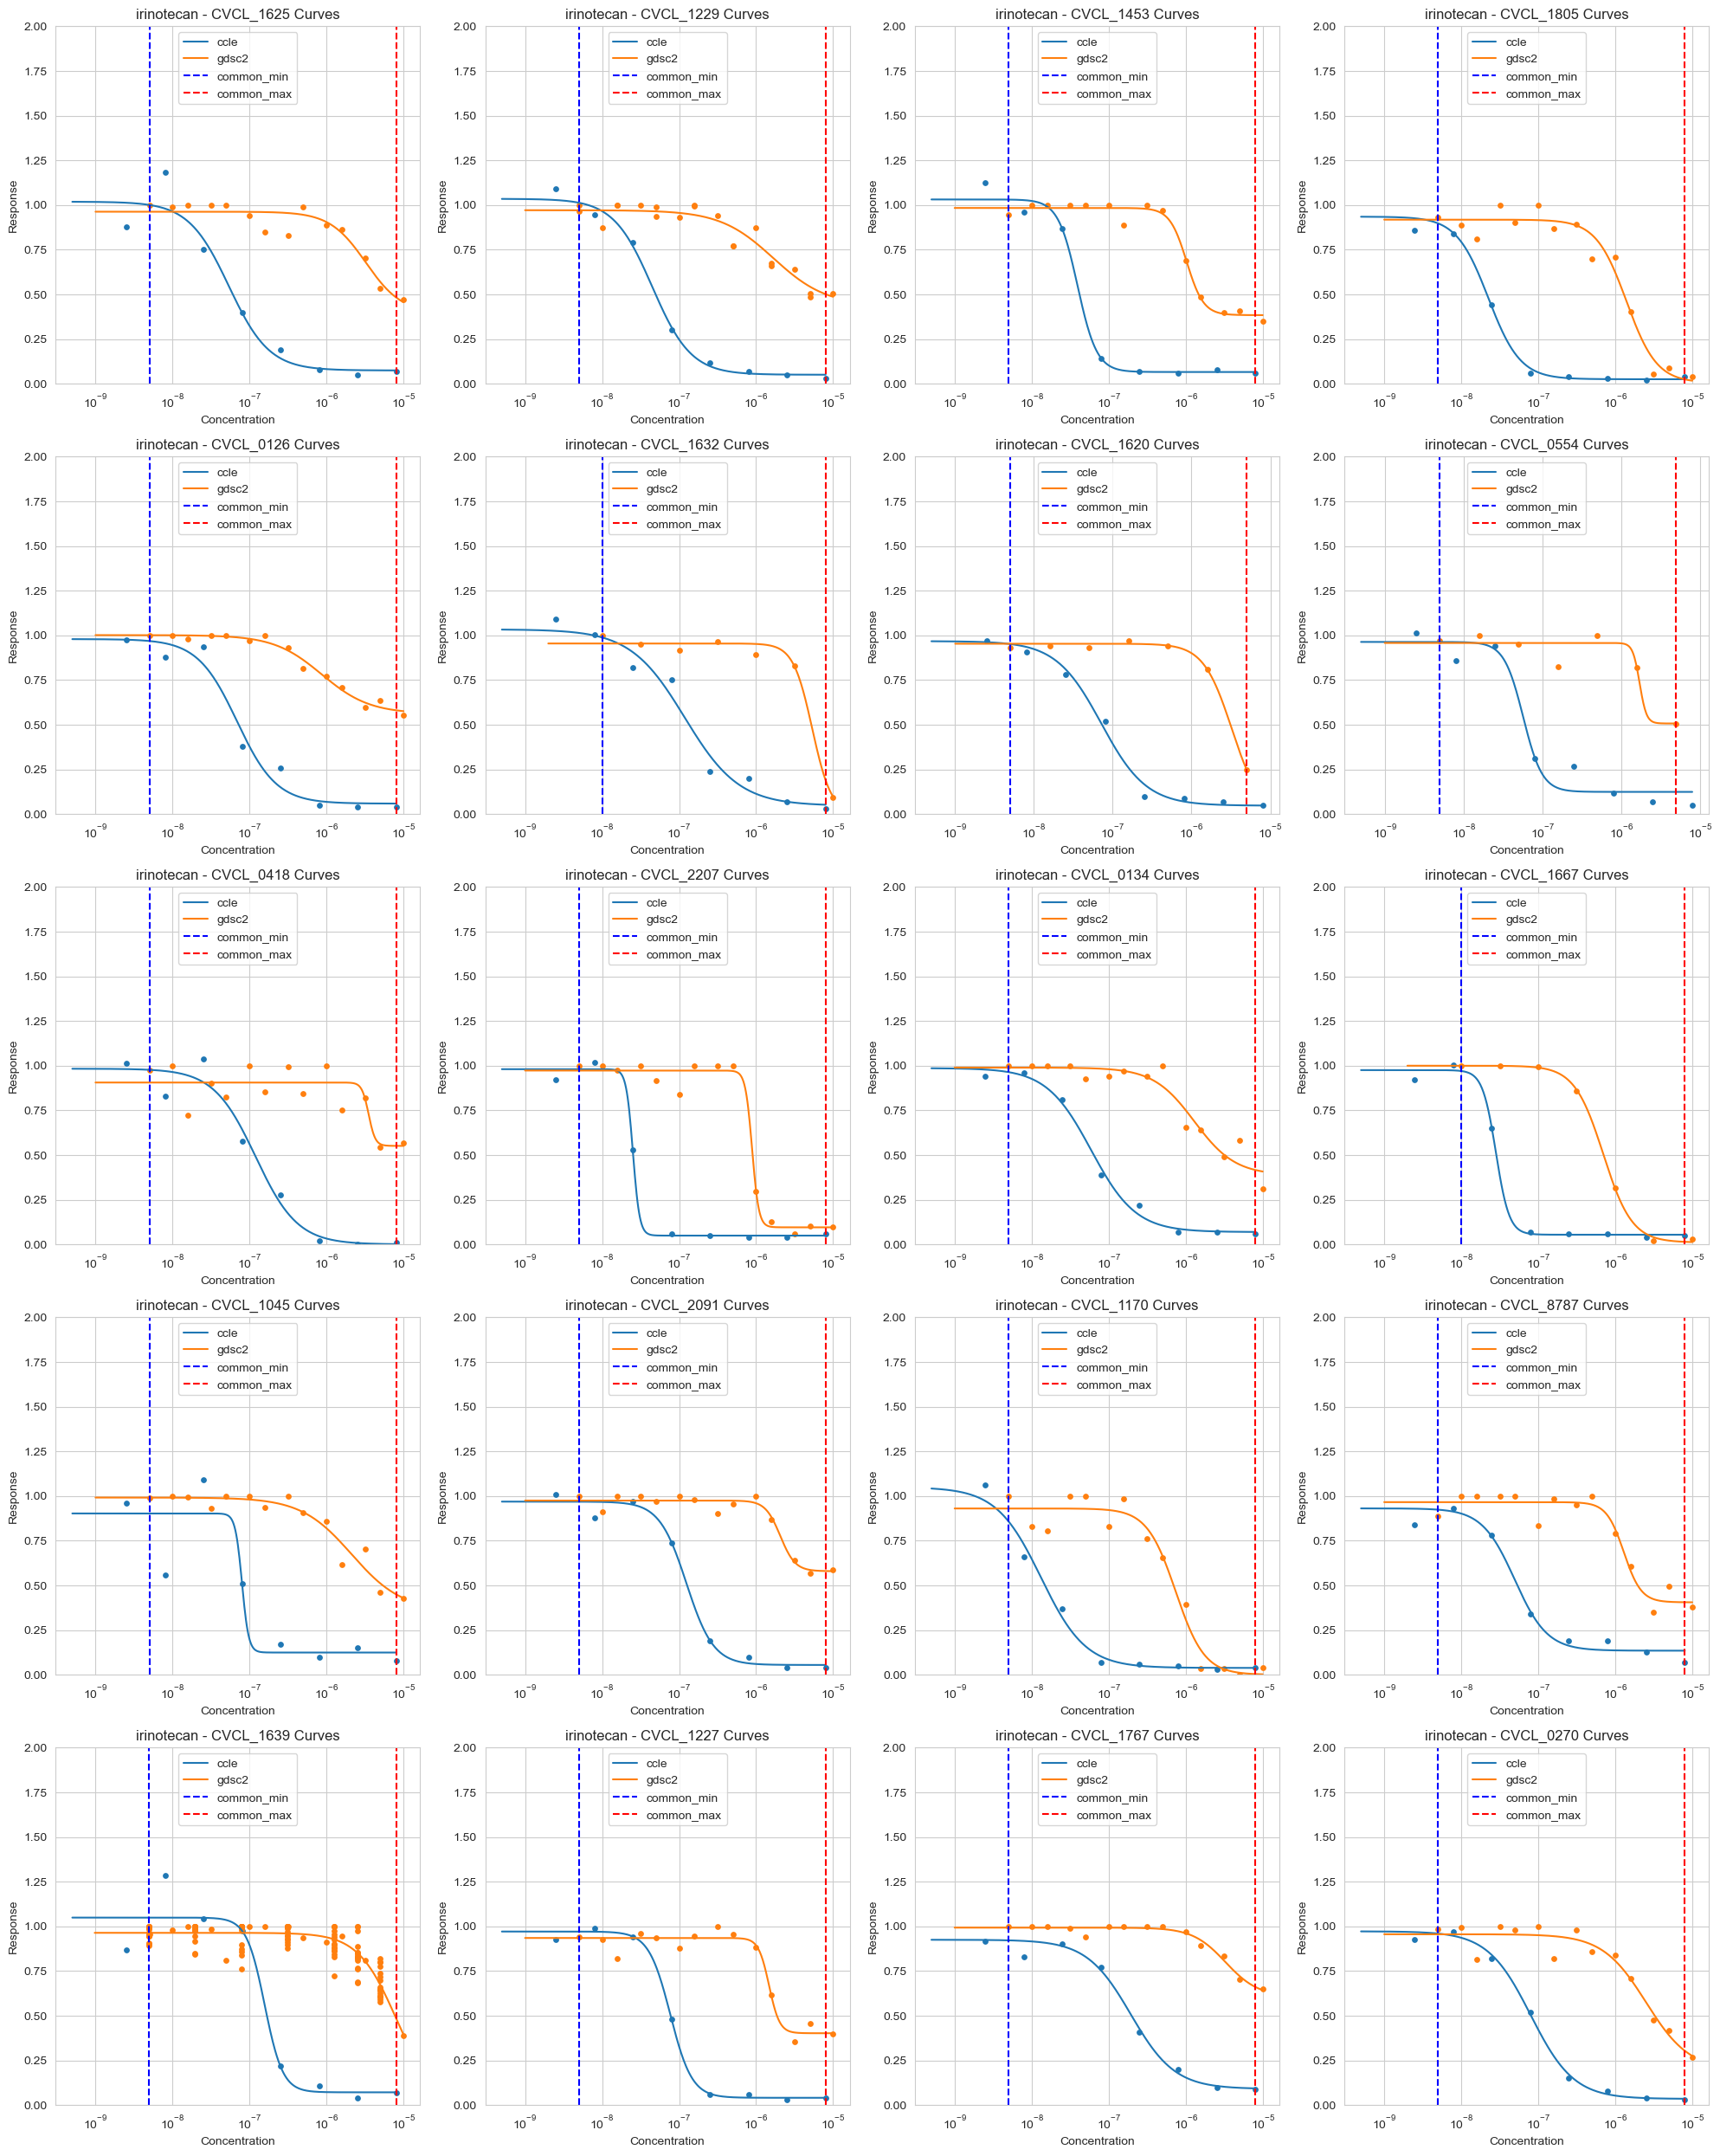

In [46]:
irinotecan = sorted_ABC[sorted_ABC['drug'] == 'irinotecan']


cell_lines = irinotecan['cell_line'][:20]

num_plots = 20
num_cols = 4  
num_rows = num_plots // num_cols if num_plots % num_cols == 0 else num_plots // num_cols + 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 25))

for i, cell in enumerate(cell_lines):
    ax = axs[i // num_cols, i % num_cols]
    Plotting.multiple_sigmoid_curves(ccle, gdsc, 'irinotecan', cell.upper(), common_conc=common_conc, ax=ax)

# Hide any unused subplots
for i in range(len(cell_lines), num_plots):
    axs[i // num_cols, i % num_cols].axis('off')

plt.tight_layout()  
plt.show()


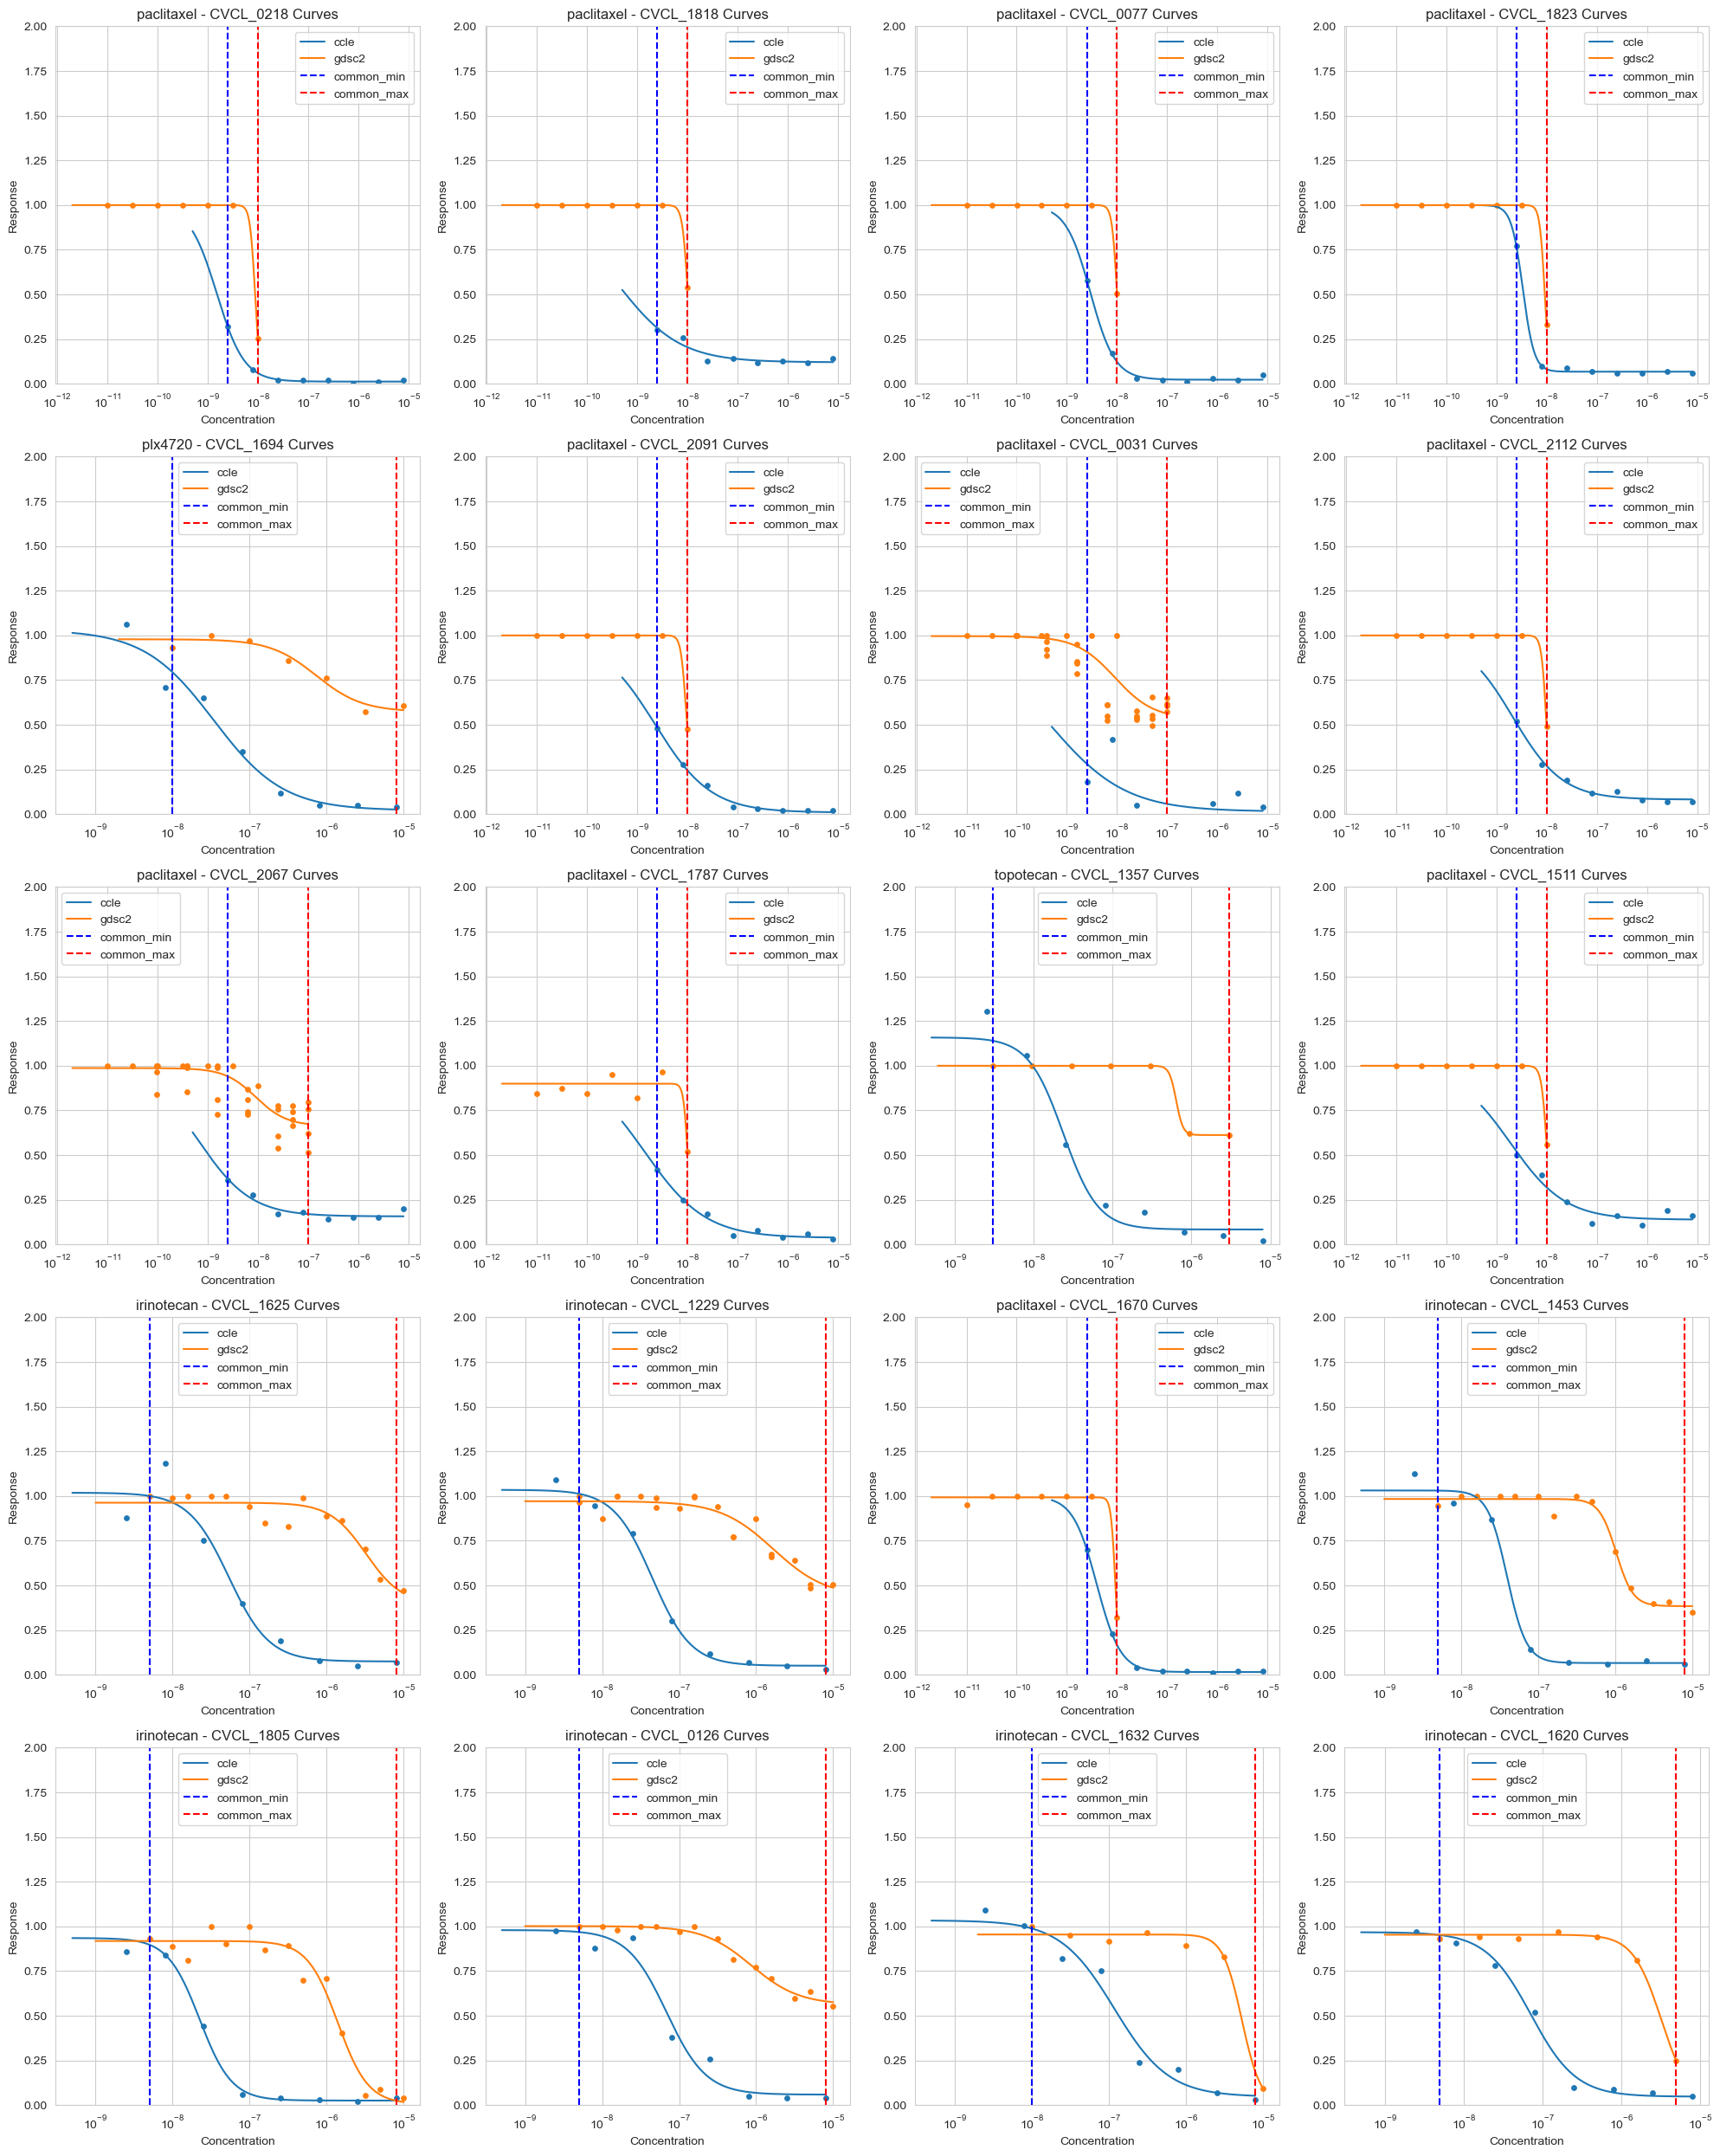

In [47]:

cell_lines = sorted_ABC[:20]

num_plots = 20
num_cols = 4  # We will arrange the plots in 4 columns.
num_rows = num_plots // num_cols if num_plots % num_cols == 0 else num_plots // num_cols + 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 25))

plot_number = 0  # Initialize plot_number
for _, row in cell_lines.iterrows():
    if plot_number >= num_plots:  # Check if we've reached the number of required plots
        break
    ax = axs[plot_number // num_cols, plot_number % num_cols]
    Plotting.multiple_sigmoid_curves(ccle, gdsc, row['drug'], row['cell_line'].upper(), common_conc=common_conc, ax=ax)
    plot_number += 1  # Increase plot_number with each loop iteration

# Hide any unused subplots
for i in range(plot_number, num_plots):
    axs[i // num_cols, i % num_cols].axis('off')

plt.tight_layout()  
plt.show()


I just wondered how ABC values would cluster together, so I'll try to use k-means clustering to find the clusters within ABC.  
First, let's determine the number of clusters.

c:\Users\SerhatBeyaz\anaconda3\envs\drop2ai\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\SerhatBeyaz\anaconda3\envs\drop2ai\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\SerhatBeyaz\anaconda3\envs\drop2ai\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\SerhatBeyaz\anaconda3\envs\drop2ai\Lib\site-packages\sklearn\cluster\_

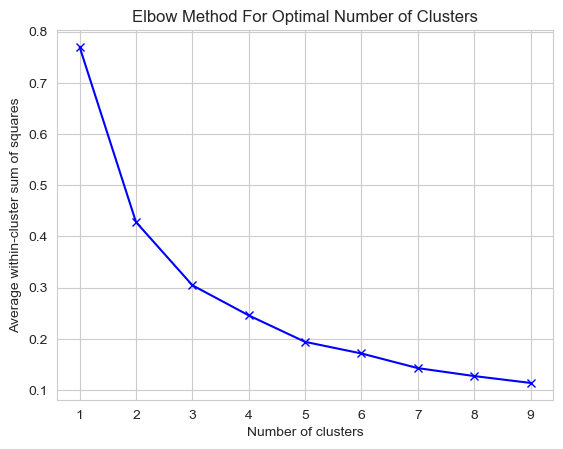

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np

ABC_values = sorted_ABC['ABC'].values.reshape(-1, 1)

# Standardize the 'ABC' values
scaler = StandardScaler()
ABC_values_scaled = scaler.fit_transform(ABC_values)

# Define a range for the number of clusters
clusters_range = range(1, 10)

# Fit the KMeans model for a range of clusters and compute the total within-cluster sum of squares for each number of clusters
within_cluster_sum_of_squares = []
for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(ABC_values_scaled)
    within_cluster_sum_of_squares.append(sum(np.min(cdist(ABC_values_scaled, kmeans.cluster_centers_, 'euclidean'), axis=1)) / ABC_values_scaled.shape[0])

# Plot the Elbow method graph
plt.plot(clusters_range, within_cluster_sum_of_squares, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()


3 looks like the optimum number of clusters

In [49]:

# Perform KMeans clustering with 3 clusters (as determined earlier)
kmeans = KMeans(n_clusters=3, random_state=0).fit(ABC_values_scaled)

# Add the cluster labels to the original dataframe
sorted_ABC['cluster'] = kmeans.labels_

# Display the first few rows of the dataframe with the cluster labels
sorted_ABC.head()


c:\Users\SerhatBeyaz\anaconda3\envs\drop2ai\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\SerhatBeyaz\anaconda3\envs\drop2ai\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


,drug,cell_line,auc_ccle,auc_gdsc,ABC,cluster
191,paclitaxel,cvcl_0218,0.841452,0.116585,0.724886,1
3883,paclitaxel,cvcl_1818,0.747101,0.057016,0.690144,1
87,paclitaxel,cvcl_0077,0.683185,0.057522,0.625778,1
1790,paclitaxel,cvcl_1823,0.688115,0.092788,0.595331,1
1542,plx4720,cvcl_1694,0.759344,0.149304,0.584298,1


I want to see how the clusters look like, thus, created a boxplot below.  
Based on the boxplot it can be said that:  
- cluster 0 = consistent ones (ABC between 0 - 0.18)
- cluster 2 = moderate inconsistency (ABC between 0.18 - 0.3)
- cluster 1 = inconsistent (ABC above 0.3)

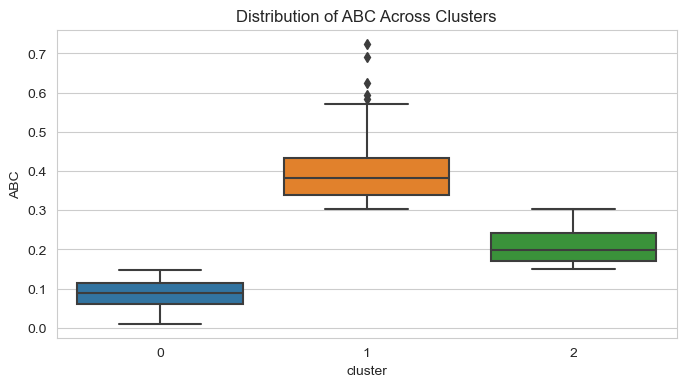

In [50]:
import seaborn as sns

continuous_vars = ['ABC']

# Plot boxplots for each continuous variable
for var in continuous_vars:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='cluster', y=var, data=sorted_ABC)
    plt.title(f'Distribution of {var} Across Clusters')
    plt.show()

In [56]:
sorted_ABC.head()

,drug,cell_line,auc_ccle,auc_gdsc,ABC,cluster
191,paclitaxel,cvcl_0218,0.841452,0.116585,0.724886,1
3883,paclitaxel,cvcl_1818,0.747101,0.057016,0.690144,1
87,paclitaxel,cvcl_0077,0.683185,0.057522,0.625778,1
1790,paclitaxel,cvcl_1823,0.688115,0.092788,0.595331,1
1542,plx4720,cvcl_1694,0.759344,0.149304,0.584298,1


I also wondered, how many times a given drug is classified as inconsistent, which gives a better idea of the worst performing drugs.  

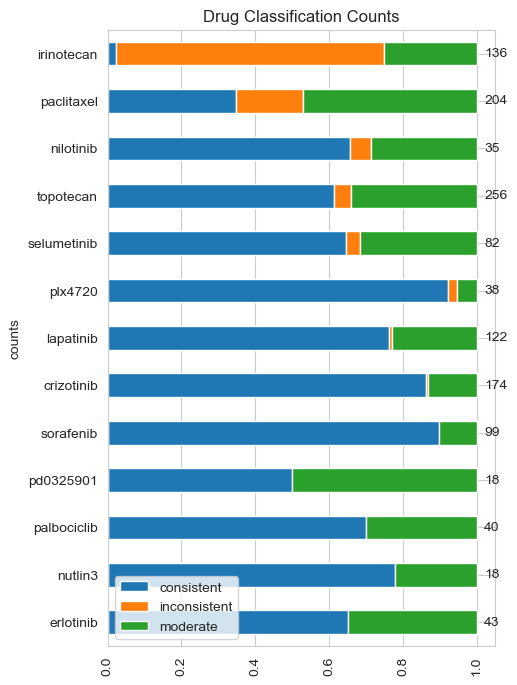

In [65]:
# Store the total counts before normalizing

cluster_counts = sorted_ABC.groupby(['drug', 'cluster']).size().reset_index(name='counts')

cluster_mapping = {0: 'consistent', 1: 'inconsistent', 2: 'moderate'}

cluster_counts['cluster'] = cluster_counts['cluster'].map(cluster_mapping)

total_counts = cluster_counts.groupby('drug')['counts'].sum()

pivot_df = cluster_counts.pivot_table(values='counts', index='drug', columns='cluster', fill_value=0)

# Normalize the counts to get fractions
pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)

# Sort pivot_df based on 'inconsistent' in descending order
pivot_df = pivot_df.sort_values('inconsistent', ascending=True)


ax = pivot_df.loc[:,['consistent', 'inconsistent', 'moderate']].plot.barh(stacked=True, figsize=(5,8))

# Annotate total counts
for i, drug in enumerate(pivot_df.index):
    ax.text(1.02, i, total_counts[drug], va='center')  # the x position 1.02 is after the end of the bar (which goes till 1.0)

plt.xticks(rotation=90)
plt.ylabel('counts')
plt.title('Drug Classification Counts')
ax.legend(loc='lower left')
plt.show()

Last but not least, what happens if we throw the most inconsistent drugs (irinotecan, paclitaxel) from the whole dataset, and then calculate the correlation

By excluding just 2 drugs, overall correlation goes from 0.67 to 0.78 (Pearson)

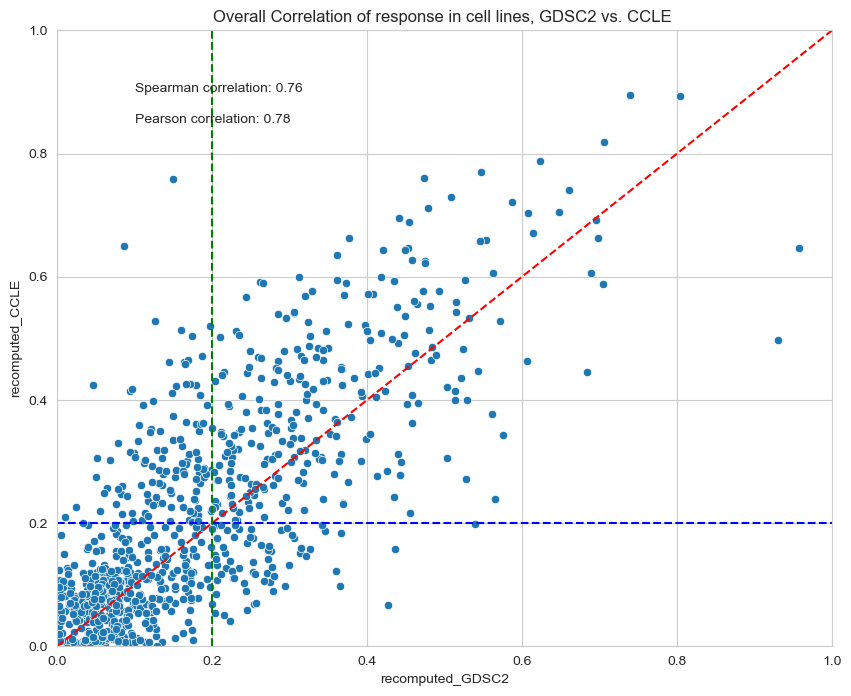

In [66]:
Plotting.correlation_plot_whole_pSet(gdsc, ccle, "recomputed", ['irinotecan', 'paclitaxel'])

### Any correlation between ABC and Seeding Density?

In [68]:
seeding_table = pd.read_csv("../../data/meta/gdsc2_seeding_density.csv")
seeding_table['cell_line'] = seeding_table['cell_line'].str.lower()

ABC_seeds = pd.merge(sorted_ABC, seeding_table, on=['cell_line', 'drug'], how= 'left')
ABC_seeds['density_ccle'] = 250

ABC_seeds['density_diff'] = abs(ABC_seeds['SEEDING_DENSITY'] - ABC_seeds['density_ccle'])
ABC_seeds

,drug,cell_line,auc_ccle,auc_gdsc,ABC,cluster,SEEDING_DENSITY,density_ccle,density_diff
0,paclitaxel,cvcl_0218,0.841452,0.116585,0.724886,1,700.0,250,450.0
1,paclitaxel,cvcl_1818,0.747101,0.057016,0.690144,1,2000.0,250,1750.0
2,paclitaxel,cvcl_0077,0.683185,0.057522,0.625778,1,300.0,250,50.0
3,paclitaxel,cvcl_1823,0.688115,0.092788,0.595331,1,2500.0,250,2250.0
4,plx4720,cvcl_1694,0.759344,0.149304,0.584298,1,625.0,250,375.0
...,...,...,...,...,...,...,...,...,...
1260,lapatinib,cvcl_1087,0.055581,0.048472,0.018997,0,625.0,250,375.0
1261,crizotinib,cvcl_1361,0.043522,0.049817,0.017840,0,400.0,250,150.0
1262,plx4720,cvcl_0556,0.041511,0.024327,0.017106,0,137.5,250,112.5
1263,sorafenib,cvcl_1402,0.073195,0.078335,0.011869,0,300.0,250,50.0


In [69]:
import pandas as pd
import numpy as np
from scipy import stats

def correlation_seed(df):

    # Remove rows with NaN or Inf
    df = df.replace([np.inf, -np.inf], np.nan)  # replace inf with NaN
    df = df.dropna(subset=['ABC', 'density_diff'])  # drop rows with NaN in 'ABC' or 'density_diff'

    
    drugs = df['drug'].unique()
    #drugs = ["irinotecan", "paclitaxel", "topotecan"]
    correlation_results = {}  # to store the correlation results

    # iterate over each drug
    for drug in drugs:
        # get subset of dataframe for the current drug
        filtered_df = df[df['drug'] == drug]

       
        #filtered_df = filtered_df[(filtered_df['auc_ccle'] > 0.1) & (filtered_df['auc_gdsc'] > 0.1)  ]
        #filtered_df = filtered_df[filtered_df['cluster']  == 1]
        
        # calculate Pearson correlation coefficient between ABC and density_diff
        corr, p_value = stats.spearmanr(filtered_df['ABC'], filtered_df['density_diff'])


        # store the result in dictionary
        drug_key = f"{drug}*" if p_value < 0.05 else drug
        correlation_results[drug_key] = {'correlation': corr, 'p_value': p_value, 'num_rows': len(filtered_df)}

    return correlation_results



In [70]:
def plot_correlation_seed(results):
    # Sort results 
    sorted_results = dict(sorted(results.items(), key=lambda item: item[1]['correlation'], reverse=True))

    drugs = [f"{drug} (n={result['num_rows']})" for drug, result in sorted_results.items()]
    correlations = [result['correlation'] for result in sorted_results.values()]

    plt.figure(figsize=(15, 5))  # increased figure size for better visibility
    plt.bar(drugs, correlations)
    plt.xlabel('Drugs')
    plt.ylabel('Correlation')
    plt.title('Correlation between ABC and density_diff for each drug (stars indicate p<0.05)')
    plt.xticks(rotation=90)  # Rotates X-Axis Ticks by 90-degrees for better visibility
    plt.ylim(-1,1)
    plt.show()


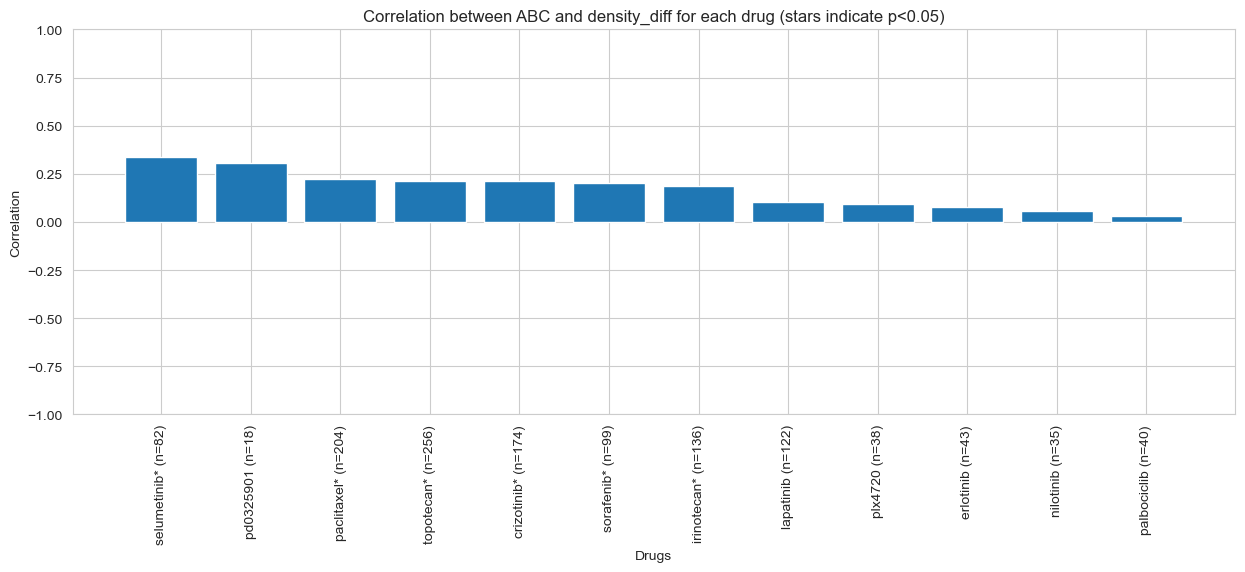

In [71]:
res2 = correlation_seed(ABC_seeds)
plot_correlation_seed(res2)

In [72]:
ABC_seeds.head()

,drug,cell_line,auc_ccle,auc_gdsc,ABC,cluster,SEEDING_DENSITY,density_ccle,density_diff
0,paclitaxel,cvcl_0218,0.841452,0.116585,0.724886,1,700.0,250,450.0
1,paclitaxel,cvcl_1818,0.747101,0.057016,0.690144,1,2000.0,250,1750.0
2,paclitaxel,cvcl_0077,0.683185,0.057522,0.625778,1,300.0,250,50.0
3,paclitaxel,cvcl_1823,0.688115,0.092788,0.595331,1,2500.0,250,2250.0
4,plx4720,cvcl_1694,0.759344,0.149304,0.584298,1,625.0,250,375.0


## Expression matrix

In [74]:
ccle_expression = pd.read_csv("../CCLe_expression_count-matrix.csv", index_col=0)
gdsc_expression = pd.read_csv("../GDSC2_expression_count-matrix.csv", index_col=0)

In [75]:
ccle_expression.head()
gdsc_expression.head()

,CVCL_0218,CVCL_0291,CVCL_0320,CVCL_1311,CVCL_0504,CVCL_5031,CVCL_5044,CVCL_5058,CVCL_1708,CVCL_1247,...,CVCL_1871,CVCL_1870,CVCL_0401,CVCL_2765,CVCL_2416,CVCL_1099,CVCL_1989,CVCL_1040,CVCL_1545,CVCL_3567
TSPAN6,7.068091,7.567510,7.354416,6.666097,7.044279,7.245454,8.779561,8.584940,10.314286,9.012194,...,3.719718,3.363823,7.652445,7.636059,8.132950,3.391213,8.890145,7.288061,6.542976,8.087337
TNMD,2.711452,2.780331,2.904234,2.674573,2.913549,2.896462,2.966783,2.776926,3.333228,2.949849,...,2.842448,2.916597,2.676371,2.616861,2.786121,2.827862,3.984019,2.922512,2.725074,2.519523
DPM1,10.366602,10.142628,10.404940,9.947170,10.593334,9.741617,10.289176,9.770002,10.810695,9.346495,...,10.389342,10.076739,10.377845,9.813502,10.119577,10.768598,9.906810,9.164292,10.153686,10.794489
SCYL3,5.312489,4.160672,4.825913,3.418023,3.681836,4.292103,4.089686,5.715959,5.668452,4.980496,...,5.095654,4.744802,3.918487,3.921414,3.757556,4.927562,3.666218,4.099015,3.977566,4.440530
C1orf112,3.354226,3.299667,3.276544,3.012762,3.348399,3.426980,3.385389,4.460420,3.220402,4.120836,...,3.558213,3.387089,3.887286,3.303692,3.180374,3.117633,3.443743,3.183865,3.103469,3.071894


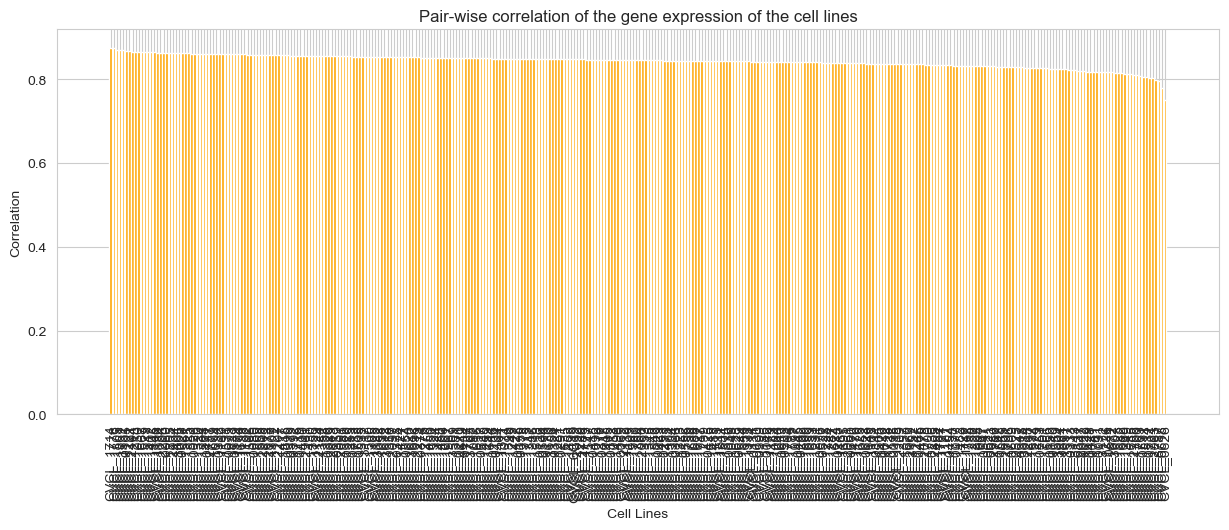

In [76]:
cell_lines = list(ABC_seeds['cell_line'].str.upper().unique())

subset_ccle = ccle_expression[ccle_expression.columns.intersection(cell_lines)]
subset_gdsc = gdsc_expression[gdsc_expression.columns.intersection(cell_lines)]

exp_corrs = subset_ccle.corrwith(subset_gdsc).dropna()
exp_corrs = exp_corrs.sort_values(ascending=False)

plt.figure(figsize=(15, 5))  # increased figure size for better visibility
plt.bar(exp_corrs.keys(), exp_corrs.values, color='orange')
plt.xlabel('Cell Lines')
plt.ylabel('Correlation')
plt.title('Pair-wise correlation of the gene expression of the cell lines')
plt.xticks(rotation=90)  # Rotates X-Axis Ticks by 90-degrees for better visibility
plt.show()
